# Clusterização em Python

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 8))
import janitor

import datetime

import sqlite3 as sql

from sklearn.cluster import KMeans
from numpy import unique
from numpy import where

#nomalizing data to its std (x_new= x/std(x))
from scipy.cluster.vq import whiten

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity="all"

## EDA Básico

## Prepara dataframe

In [3]:
!ls ../../dados/sql

base_completa.db  Normalização_03.ipynb


In [4]:
#Dados de parlamentares
con = sql.connect("../../dados/sql/base_completa.db")
df_deputados=pd.read_sql("select * from deputados_cadastro",con)
df_diap=pd.read_sql("select * from diap",con)
con.close()

In [5]:
df_deputados.info()
df_diap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CPF                      514 non-null    object 
 1   NM_CANDIDATO             514 non-null    object 
 2   DT_NASCIMENTO            514 non-null    object 
 3   SG_UF_NASCIMENTO         514 non-null    object 
 4   NM_MUNICIPIO_NASCIMENTO  514 non-null    object 
 5   DS_GENERO                514 non-null    object 
 6   DS_GRAU_INSTRUCAO        514 non-null    object 
 7   DS_ESTADO_CIVIL          514 non-null    object 
 8   DS_COR_RACA              514 non-null    object 
 9   DS_OCUPACAO              514 non-null    object 
 10  VL_BENS                  514 non-null    float64
 11  ANO_ELEICAO              514 non-null    int64  
 12  DS_CARGO                 514 non-null    object 
 13  SG_PARTIDO               514 non-null    object 
 14  SG_UE                    5

In [6]:
df=pd.merge(df_deputados,df_diap, how="left", on="CPF")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514 entries, 0 to 513
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CPF                      514 non-null    object 
 1   NM_CANDIDATO             514 non-null    object 
 2   DT_NASCIMENTO            514 non-null    object 
 3   SG_UF_NASCIMENTO         514 non-null    object 
 4   NM_MUNICIPIO_NASCIMENTO  514 non-null    object 
 5   DS_GENERO                514 non-null    object 
 6   DS_GRAU_INSTRUCAO        514 non-null    object 
 7   DS_ESTADO_CIVIL          514 non-null    object 
 8   DS_COR_RACA              514 non-null    object 
 9   DS_OCUPACAO              514 non-null    object 
 10  VL_BENS                  514 non-null    float64
 11  ANO_ELEICAO              514 non-null    int64  
 12  DS_CARGO                 514 non-null    object 
 13  SG_PARTIDO               514 non-null    object 
 14  SG_UE                    5

In [8]:
df.head()

,CPF,NM_CANDIDATO,DT_NASCIMENTO,SG_UF_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,DS_COR_RACA,DS_OCUPACAO,...,LEG_INICIAL,REDE_SOCIAL,WEB_SITE,ID_URL,mandatos,cabeças,debatedor,articulador,formulador,negociador
0,00413473740,JOZIEL FERREIRA CARLOS,22/04/1966,RJ,SÃO JOÃO DE MERITI,MASCULINO,SUPERIOR COMPLETO,CASADO(A),PRETA,MILITAR REFORMADO,...,56.0,None,None,https://dadosabertos.camara.leg.br/api/v2/depu...,NaN,NaN,NaN,NaN,NaN,NaN
1,01171688075,LUIS ANTONIO FRANCISCATTO COVATTI,25/07/1987,RS,FREDERICO WESTPHALEN,MASCULINO,SUPERIOR INCOMPLETO,SOLTEIRO(A),BRANCA,DEPUTADO,...,55.0,None,None,https://dadosabertos.camara.leg.br/api/v2/depu...,NaN,NaN,NaN,NaN,NaN,NaN
2,38167565300,ANTONIO IDILVAN DE LIMA ALENCAR,23/09/1968,CE,CRATO,MASCULINO,SUPERIOR COMPLETO,SOLTEIRO(A),BRANCA,SERVIDOR PÚBLICO ESTADUAL,...,56.0,None,None,https://dadosabertos.camara.leg.br/api/v2/depu...,NaN,NaN,NaN,NaN,NaN,NaN
3,22977040544,MANOEL ISIDORIO DE SANTANA JUNIOR,28/07/1962,BA,SALVADOR,MASCULINO,SUPERIOR INCOMPLETO,CASADO(A),PRETA,DEPUTADO,...,56.0,None,None,https://dadosabertos.camara.leg.br/api/v2/depu...,NaN,NaN,NaN,NaN,NaN,NaN
4,10851776884,ROSANA DE OLIVEIRA VALLE,08/05/1969,SP,SANTOS,FEMININO,SUPERIOR COMPLETO,CASADO(A),BRANCA,JORNALISTA E REDATOR,...,56.0,"RosanaValleOficial, rosanavalleoficial, DepR...",None,https://dadosabertos.camara.leg.br/api/v2/depu...,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
hoje=datetime.datetime.now()
df["IDADE"]=df["DT_NASCIMENTO"].apply(lambda x:(hoje-datetime.datetime.strptime(x, '%d/%m/%Y')).days//(365.25))

In [10]:
df.sample(5)

,CPF,NM_CANDIDATO,DT_NASCIMENTO,SG_UF_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,DS_COR_RACA,DS_OCUPACAO,...,REDE_SOCIAL,WEB_SITE,ID_URL,mandatos,cabeças,debatedor,articulador,formulador,negociador,IDADE
288,84470666653,EROS FERREIRA BIONDINI,20/05/1971,MG,BELO HORIZONTE,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BRANCA,DEPUTADO,...,"http://twitter.com/erosbiondini, http://www.f...",http://www.erosbiondini.com,https://dadosabertos.camara.leg.br/api/v2/depu...,NaN,NaN,NaN,NaN,NaN,NaN,49.0
185,96311380110,ISRAEL MATOS BATISTA,02/05/1982,DF,BRASILIA,MASCULINO,SUPERIOR COMPLETO,DIVORCIADO(A),BRANCA,PROFESSOR DE ENSINO MÉDIO,...,None,None,https://dadosabertos.camara.leg.br/api/v2/depu...,NaN,NaN,NaN,NaN,NaN,NaN,38.0
477,48989371015,MARIA DO ROSÁRIO NUNES,22/11/1966,RS,VERANÓPOLIS,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),BRANCA,PROFESSOR DE ENSINO FUNDAMENTAL,...,"DeputadaMariaDoRosario, _mariadorosario, @ma...",None,https://dadosabertos.camara.leg.br/api/v2/depu...,NaN,NaN,NaN,NaN,NaN,NaN,53.0
218,13717820249,JOÃO BOSCO GOMES SARAIVA,10/10/1959,AM,MANAUS,MASCULINO,SUPERIOR COMPLETO,CASADO(A),PARDA,OUTROS,...,None,None,https://dadosabertos.camara.leg.br/api/v2/depu...,NaN,NaN,NaN,NaN,NaN,NaN,60.0
239,22970812860,ALEXANDRE LEITE DA SILVA,18/04/1989,SP,SÃO PAULO,MASCULINO,SUPERIOR COMPLETO,SOLTEIRO(A),BRANCA,DEPUTADO,...,None,None,https://dadosabertos.camara.leg.br/api/v2/depu...,NaN,NaN,NaN,NaN,NaN,NaN,31.0


In [11]:
df.columns

Index(['CPF', 'NM_CANDIDATO', 'DT_NASCIMENTO', 'SG_UF_NASCIMENTO',
       'NM_MUNICIPIO_NASCIMENTO', 'DS_GENERO', 'DS_GRAU_INSTRUCAO',
       'DS_ESTADO_CIVIL', 'DS_COR_RACA', 'DS_OCUPACAO', 'VL_BENS',
       'ANO_ELEICAO', 'DS_CARGO', 'SG_PARTIDO', 'SG_UE', 'SQ_CANDIDATO',
       'NM_URNA_CANDIDATO', 'NR_IDADE_DATA_POSSE', 'NM_EMAIL',
       'VR_DESPESA_CONTRATADA', 'ID_CAMARA', 'NM_PUBLICO', 'LEG_INICIAL',
       'REDE_SOCIAL', 'WEB_SITE', 'ID_URL', 'mandatos', 'cabeças', 'debatedor',
       'articulador', 'formulador', 'negociador', 'IDADE'],
      dtype='object')

In [12]:
df=df[['CPF', 'NM_PUBLICO','DS_GENERO', 'DS_GRAU_INSTRUCAO',
       'DS_ESTADO_CIVIL', 'SG_UF_NASCIMENTO', 'IDADE','DS_COR_RACA', 'DS_OCUPACAO', 'VL_BENS',
        'ID_CAMARA', 'SG_PARTIDO', 'SG_UE','VR_DESPESA_CONTRATADA', 'LEG_INICIAL',
        'mandatos', 'cabeças', 'debatedor','articulador', 'formulador', 'negociador']].copy()

In [13]:
df.columns

Index(['CPF', 'NM_PUBLICO', 'DS_GENERO', 'DS_GRAU_INSTRUCAO',
       'DS_ESTADO_CIVIL', 'SG_UF_NASCIMENTO', 'IDADE', 'DS_COR_RACA',
       'DS_OCUPACAO', 'VL_BENS', 'ID_CAMARA', 'SG_PARTIDO', 'SG_UE',
       'VR_DESPESA_CONTRATADA', 'LEG_INICIAL', 'mandatos', 'cabeças',
       'debatedor', 'articulador', 'formulador', 'negociador'],
      dtype='object')

In [14]:
df.shape
df.info()
df.sample(10)

(514, 21)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514 entries, 0 to 513
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CPF                    514 non-null    object 
 1   NM_PUBLICO             513 non-null    object 
 2   DS_GENERO              514 non-null    object 
 3   DS_GRAU_INSTRUCAO      514 non-null    object 
 4   DS_ESTADO_CIVIL        514 non-null    object 
 5   SG_UF_NASCIMENTO       514 non-null    object 
 6   IDADE                  514 non-null    float64
 7   DS_COR_RACA            514 non-null    object 
 8   DS_OCUPACAO            514 non-null    object 
 9   VL_BENS                514 non-null    float64
 10  ID_CAMARA              513 non-null    object 
 11  SG_PARTIDO             514 non-null    object 
 12  SG_UE                  514 non-null    object 
 13  VR_DESPESA_CONTRATADA  514 non-null    float64
 14  LEG_INICIAL            513 non-null    float64
 15  mandat

,CPF,NM_PUBLICO,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,SG_UF_NASCIMENTO,IDADE,DS_COR_RACA,DS_OCUPACAO,VL_BENS,...,SG_PARTIDO,SG_UE,VR_DESPESA_CONTRATADA,LEG_INICIAL,mandatos,cabeças,debatedor,articulador,formulador,negociador
202,67821090425,Arthur Lira,MASCULINO,SUPERIOR COMPLETO,CASADO(A),AL,51.0,PARDA,DEPUTADO,1718924.20,...,PP,AL,1765947.26,54.0,3.0,3.0,0.0,1.0,0.0,0.0
424,48140597368,Capitão Fábio Abreu,MASCULINO,SUPERIOR COMPLETO,SOLTEIRO(A),CE,47.0,PARDA,DEPUTADO,882176.38,...,PR,PI,1452494.78,55.0,NaN,NaN,NaN,NaN,NaN,NaN
434,01266637699,Newton Cardoso Jr,MASCULINO,SUPERIOR COMPLETO,CASADO(A),MG,40.0,BRANCA,DEPUTADO,2030880.92,...,MDB,MG,2060281.96,55.0,NaN,NaN,NaN,NaN,NaN,NaN
458,51150670215,Aline Gurgel,FEMININO,SUPERIOR COMPLETO,CASADO(A),AP,39.0,BRANCA,ADVOGADO,0.00,...,PRB,AP,1952424.60,56.0,NaN,NaN,NaN,NaN,NaN,NaN
31,43422780653,Zé Silva,MASCULINO,SUPERIOR COMPLETO,CASADO(A),MG,57.0,BRANCA,ENGENHEIRO,1438990.18,...,SOLIDARIEDADE,MG,1649459.64,54.0,NaN,NaN,NaN,NaN,NaN,NaN
292,67871224549,Otto Alencar Filho,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BA,43.0,BRANCA,ADMINISTRADOR,1063693.66,...,PSD,BA,904075.87,56.0,NaN,NaN,NaN,NaN,NaN,NaN
259,95887105020,Maurício Dziedricki,MASCULINO,SUPERIOR COMPLETO,SOLTEIRO(A),PR,41.0,BRANCA,DEPUTADO,308989.06,...,PTB,RS,909476.06,54.0,NaN,NaN,NaN,NaN,NaN,NaN
413,04789113515,José Rocha,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BA,72.0,BRANCA,MÉDICO,6966401.79,...,PR,BA,1396070.60,50.0,NaN,NaN,NaN,NaN,NaN,NaN
143,49941720053,Sanderson,MASCULINO,SUPERIOR COMPLETO,CASADO(A),RS,50.0,BRANCA,SERVIDOR PÚBLICO FEDERAL,985000.00,...,PSL,RS,92508.29,56.0,NaN,NaN,NaN,NaN,NaN,NaN
416,02142743730,Carlos Gomes,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),BA,48.0,BRANCA,OUTROS,121327.95,...,PRB,RS,881096.17,55.0,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df.info()
df.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514 entries, 0 to 513
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CPF                    514 non-null    object 
 1   NM_PUBLICO             513 non-null    object 
 2   DS_GENERO              514 non-null    object 
 3   DS_GRAU_INSTRUCAO      514 non-null    object 
 4   DS_ESTADO_CIVIL        514 non-null    object 
 5   SG_UF_NASCIMENTO       514 non-null    object 
 6   IDADE                  514 non-null    float64
 7   DS_COR_RACA            514 non-null    object 
 8   DS_OCUPACAO            514 non-null    object 
 9   VL_BENS                514 non-null    float64
 10  ID_CAMARA              513 non-null    object 
 11  SG_PARTIDO             514 non-null    object 
 12  SG_UE                  514 non-null    object 
 13  VR_DESPESA_CONTRATADA  514 non-null    float64
 14  LEG_INICIAL            513 non-null    float64
 15  mandat

,IDADE,VL_BENS,VR_DESPESA_CONTRATADA,LEG_INICIAL,mandatos,cabeças,debatedor,articulador,formulador,negociador
count,514.00,5.140000e+02,514.00,513.00,71.00,71.00,71.00,71.00,71.0,71.00
mean,50.68,2.121679e+06,1083318.32,54.60,3.25,5.06,0.28,0.39,0.1,0.23
std,11.91,6.331941e+06,677683.78,1.95,1.83,5.33,0.45,0.49,0.3,0.42
min,24.00,0.000000e+00,10291.00,44.00,1.00,1.00,0.00,0.00,0.0,0.00
25%,41.00,3.573077e+05,510534.54,54.00,2.00,1.00,0.00,0.00,0.0,0.00
50%,51.00,9.306238e+05,1021760.94,55.00,3.00,3.00,0.00,0.00,0.0,0.00
75%,59.75,1.839741e+06,1587261.02,56.00,5.00,8.00,1.00,1.00,0.0,0.00
max,85.00,1.198105e+08,2591858.00,56.00,7.00,22.00,1.00,1.00,1.0,1.00


In [16]:
df.fillna(0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514 entries, 0 to 513
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CPF                    514 non-null    object 
 1   NM_PUBLICO             514 non-null    object 
 2   DS_GENERO              514 non-null    object 
 3   DS_GRAU_INSTRUCAO      514 non-null    object 
 4   DS_ESTADO_CIVIL        514 non-null    object 
 5   SG_UF_NASCIMENTO       514 non-null    object 
 6   IDADE                  514 non-null    float64
 7   DS_COR_RACA            514 non-null    object 
 8   DS_OCUPACAO            514 non-null    object 
 9   VL_BENS                514 non-null    float64
 10  ID_CAMARA              514 non-null    object 
 11  SG_PARTIDO             514 non-null    object 
 12  SG_UE                  514 non-null    object 
 13  VR_DESPESA_CONTRATADA  514 non-null    float64
 14  LEG_INICIAL            514 non-null    float64
 15  mandat

In [17]:
df.describe(include=np.object)

,CPF,NM_PUBLICO,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,SG_UF_NASCIMENTO,DS_COR_RACA,DS_OCUPACAO,ID_CAMARA,SG_PARTIDO,SG_UE
count,514,514,514,514,514,514,514,514,514,514,514
unique,513,514,2,7,5,27,5,47,514,30,27
top,00558574181,Ricardo Teobaldo,MASCULINO,SUPERIOR COMPLETO,CASADO(A),SP,BRANCA,DEPUTADO,204540,PT,SP
freq,2,1,437,414,357,67,386,234,1,54,70


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f590e3bd150>,
      dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 864x576 with 0 Axes>

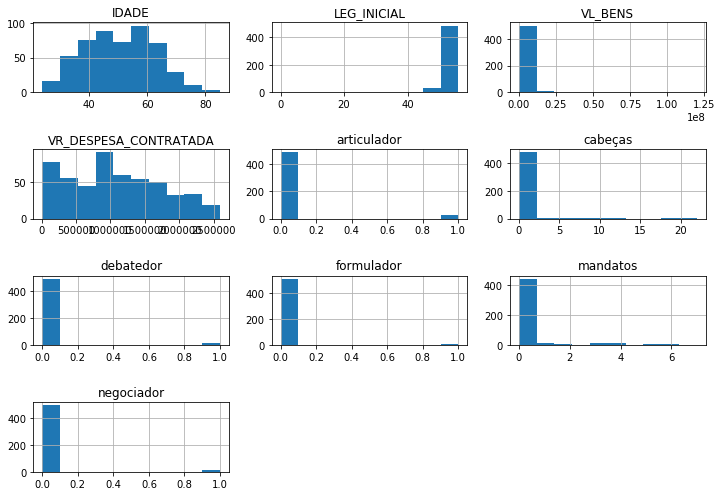

In [18]:
plt.clf()
df.hist(figsize=(10,7))
plt.tight_layout()
plt.show

In [19]:
df.info()
unicos=df.nunique()
unicos

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514 entries, 0 to 513
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CPF                    514 non-null    object 
 1   NM_PUBLICO             514 non-null    object 
 2   DS_GENERO              514 non-null    object 
 3   DS_GRAU_INSTRUCAO      514 non-null    object 
 4   DS_ESTADO_CIVIL        514 non-null    object 
 5   SG_UF_NASCIMENTO       514 non-null    object 
 6   IDADE                  514 non-null    float64
 7   DS_COR_RACA            514 non-null    object 
 8   DS_OCUPACAO            514 non-null    object 
 9   VL_BENS                514 non-null    float64
 10  ID_CAMARA              514 non-null    object 
 11  SG_PARTIDO             514 non-null    object 
 12  SG_UE                  514 non-null    object 
 13  VR_DESPESA_CONTRATADA  514 non-null    float64
 14  LEG_INICIAL            514 non-null    float64
 15  mandat

CPF                      513
NM_PUBLICO               514
DS_GENERO                  2
DS_GRAU_INSTRUCAO          7
DS_ESTADO_CIVIL            5
SG_UF_NASCIMENTO          27
IDADE                     57
DS_COR_RACA                5
DS_OCUPACAO               47
VL_BENS                  489
ID_CAMARA                514
SG_PARTIDO                30
SG_UE                     27
VR_DESPESA_CONTRATADA    513
LEG_INICIAL               12
mandatos                   8
cabeças                   19
debatedor                  2
articulador                2
formulador                 2
negociador                 2
dtype: int64

In [20]:
# Tentar as que tem até 3
unicas=47
variaveis_categoricas=[]
for variavel in unicos.index:
    quant=unicos.loc[variavel]
    if quant <= unicas:
        variaveis_categoricas.append(variavel)
        print("Variavel {}, {} ocorrências únicas".format(variavel,quant))
        print(df[variavel].sort_values().unique())

Variavel DS_GENERO, 2 ocorrências únicas
['FEMININO' 'MASCULINO']
Variavel DS_GRAU_INSTRUCAO, 7 ocorrências únicas
['ENSINO FUNDAMENTAL COMPLETO' 'ENSINO FUNDAMENTAL INCOMPLETO'
 'ENSINO MÉDIO COMPLETO' 'ENSINO MÉDIO INCOMPLETO' 'LÊ E ESCREVE'
 'SUPERIOR COMPLETO' 'SUPERIOR INCOMPLETO']
Variavel DS_ESTADO_CIVIL, 5 ocorrências únicas
['CASADO(A)' 'DIVORCIADO(A)' 'SEPARADO(A) JUDICIALMENTE' 'SOLTEIRO(A)'
 'VIÚVO(A)']
Variavel SG_UF_NASCIMENTO, 27 ocorrências únicas
['AC' 'AL' 'AM' 'AP' 'BA' 'CE' 'DF' 'ES' 'GO' 'MA' 'MG' 'MS' 'MT' 'PA'
 'PB' 'PE' 'PI' 'PR' 'RJ' 'RN' 'RO' 'RR' 'RS' 'SC' 'SE' 'SP' 'ZZ']
Variavel DS_COR_RACA, 5 ocorrências únicas
['AMARELA' 'BRANCA' 'INDÍGENA' 'PARDA' 'PRETA']
Variavel DS_OCUPACAO, 47 ocorrências únicas
['ADMINISTRADOR' 'ADVOGADO' 'AGENTE ADMINISTRATIVO' 'AGRICULTOR'
 'APOSENTADO (EXCETO SERVIDOR PÚBLICO)' 'ASSISTENTE SOCIAL'
 'BANCÁRIO E ECONOMIÁRIO' 'BOMBEIRO MILITAR' 'CIENTISTA POLÍTICO'
 'COMERCIANTE' 'COMERCIÁRIO' 'COMUNICÓLOGO' 'CONTADOR'
 'CORRETOR DE

In [21]:
variaveis_categoricas

['DS_GENERO',
 'DS_GRAU_INSTRUCAO',
 'DS_ESTADO_CIVIL',
 'SG_UF_NASCIMENTO',
 'DS_COR_RACA',
 'DS_OCUPACAO',
 'SG_PARTIDO',
 'SG_UE',
 'LEG_INICIAL',
 'mandatos',
 'cabeças',
 'debatedor',
 'articulador',
 'formulador',
 'negociador']

In [22]:
#variaveis_categoricas.remove("time_spend_company")
variaveis_categoricas


['DS_GENERO',
 'DS_GRAU_INSTRUCAO',
 'DS_ESTADO_CIVIL',
 'SG_UF_NASCIMENTO',
 'DS_COR_RACA',
 'DS_OCUPACAO',
 'SG_PARTIDO',
 'SG_UE',
 'LEG_INICIAL',
 'mandatos',
 'cabeças',
 'debatedor',
 'articulador',
 'formulador',
 'negociador']

In [23]:
df[variaveis_categoricas].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 514 entries, 0 to 513
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DS_GENERO          514 non-null    object 
 1   DS_GRAU_INSTRUCAO  514 non-null    object 
 2   DS_ESTADO_CIVIL    514 non-null    object 
 3   SG_UF_NASCIMENTO   514 non-null    object 
 4   DS_COR_RACA        514 non-null    object 
 5   DS_OCUPACAO        514 non-null    object 
 6   SG_PARTIDO         514 non-null    object 
 7   SG_UE              514 non-null    object 
 8   LEG_INICIAL        514 non-null    float64
 9   mandatos           514 non-null    float64
 10  cabeças            514 non-null    float64
 11  debatedor          514 non-null    float64
 12  articulador        514 non-null    float64
 13  formulador         514 non-null    float64
 14  negociador         514 non-null    float64
dtypes: float64(7), object(8)
memory usage: 64.2+ KB


In [24]:
#variaveis_dummy=variaveis_categoricas[0:3]
variaveis_dummy=[]

In [25]:
for variavel in variaveis_categoricas:
    df[variavel]=df[variavel].astype("category")
df.info()
#df.describe(include=np.object)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514 entries, 0 to 513
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   CPF                    514 non-null    object  
 1   NM_PUBLICO             514 non-null    object  
 2   DS_GENERO              514 non-null    category
 3   DS_GRAU_INSTRUCAO      514 non-null    category
 4   DS_ESTADO_CIVIL        514 non-null    category
 5   SG_UF_NASCIMENTO       514 non-null    category
 6   IDADE                  514 non-null    float64 
 7   DS_COR_RACA            514 non-null    category
 8   DS_OCUPACAO            514 non-null    category
 9   VL_BENS                514 non-null    float64 
 10  ID_CAMARA              514 non-null    object  
 11  SG_PARTIDO             514 non-null    category
 12  SG_UE                  514 non-null    category
 13  VR_DESPESA_CONTRATADA  514 non-null    float64 
 14  LEG_INICIAL            514 non-null    cat

In [26]:
variaveis_numericas=list((df.columns))
variaveis_numericas=list(set(variaveis_numericas)-set(variaveis_categoricas))
variaveis_numericas

['CPF', 'NM_PUBLICO', 'IDADE', 'VR_DESPESA_CONTRATADA', 'ID_CAMARA', 'VL_BENS']

In [27]:
variaveis_numericas.remove("NM_PUBLICO")
variaveis_numericas.remove("CPF")
variaveis_numericas.remove("ID_CAMARA")

### Histogramas

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'DS_GENERO')

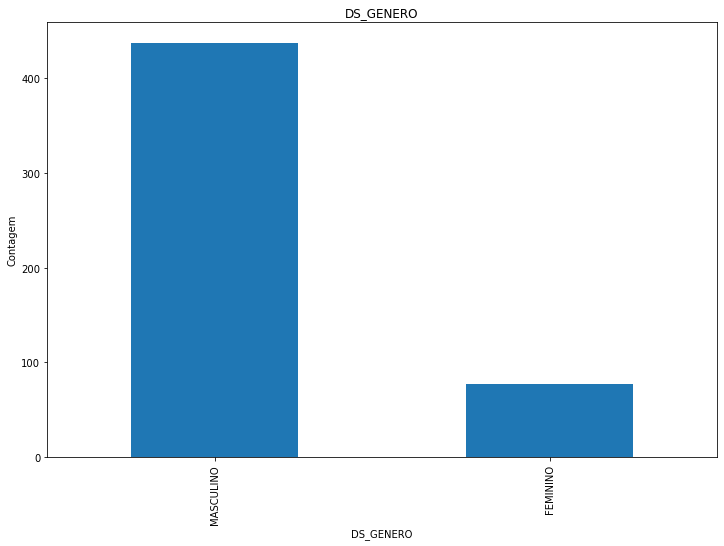

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

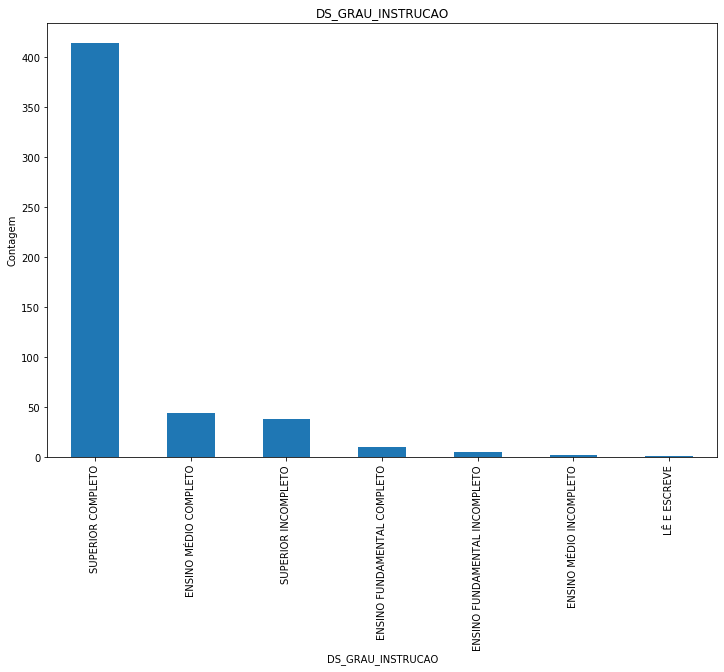

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

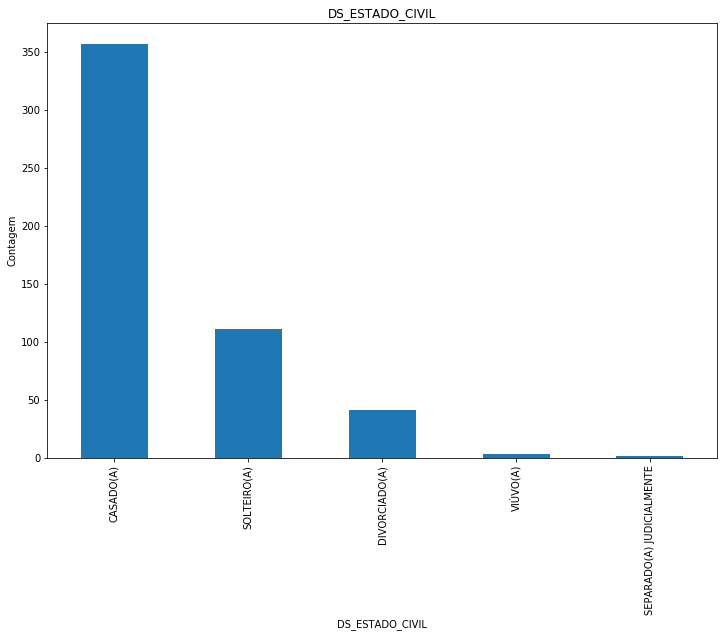

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

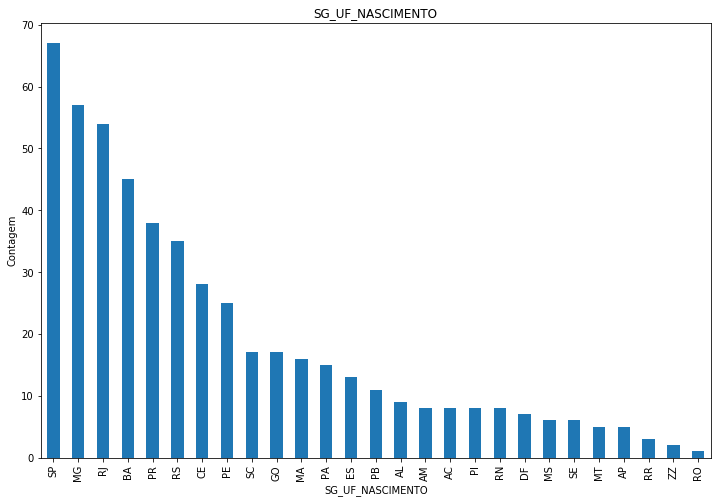

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'DS_COR_RACA')

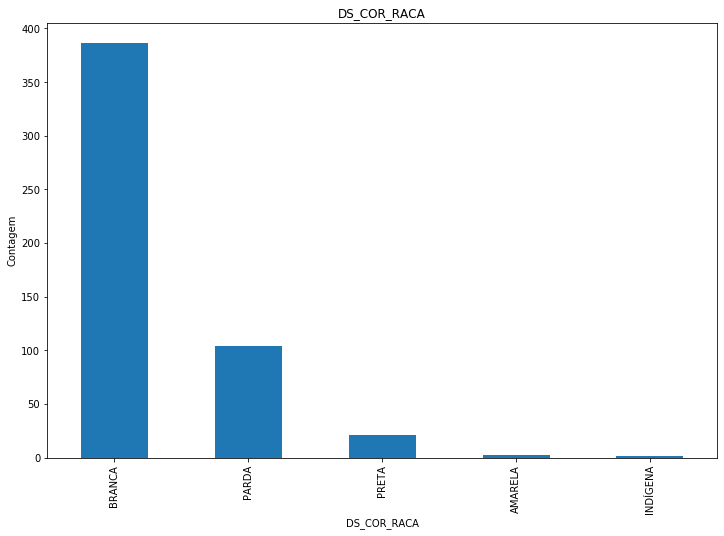

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'DS_OCUPACAO')

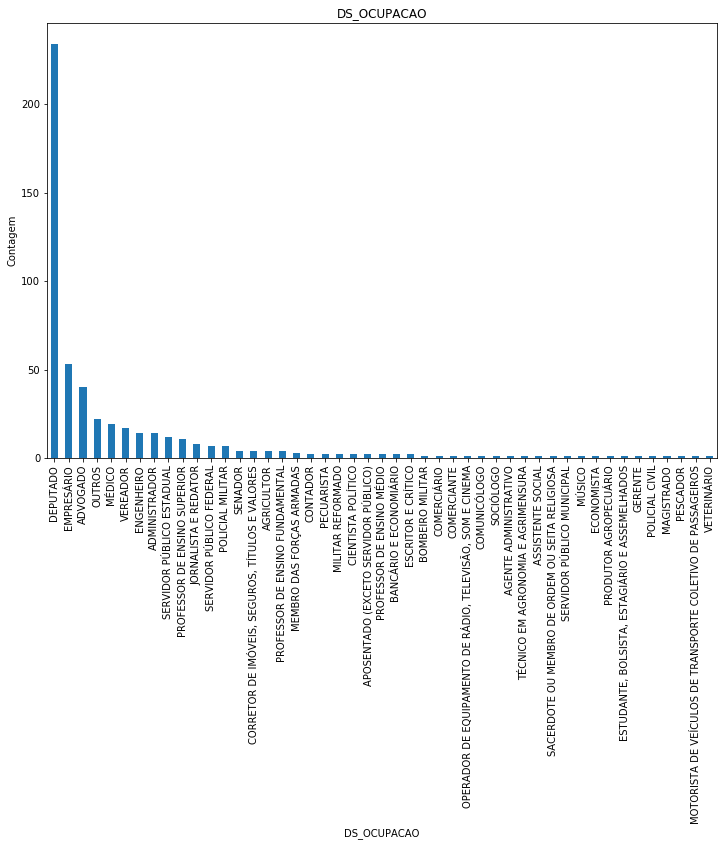

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'SG_PARTIDO')

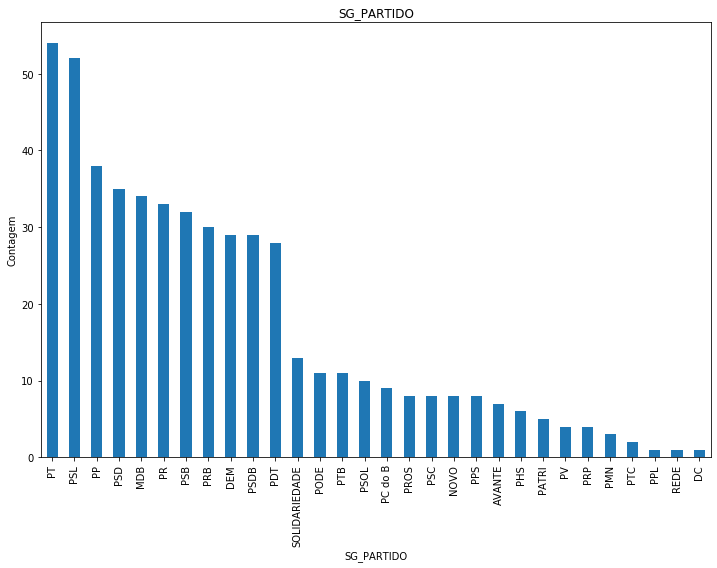

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'SG_UE')

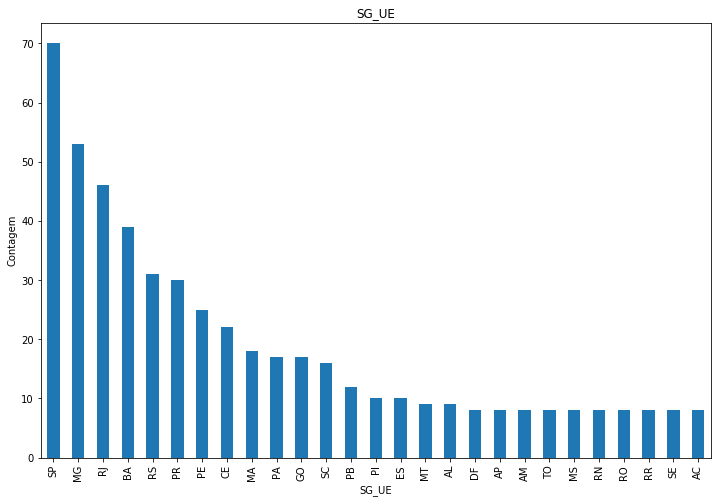

Text(0.5, 0, 'LEG_INICIAL')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'LEG_INICIAL')

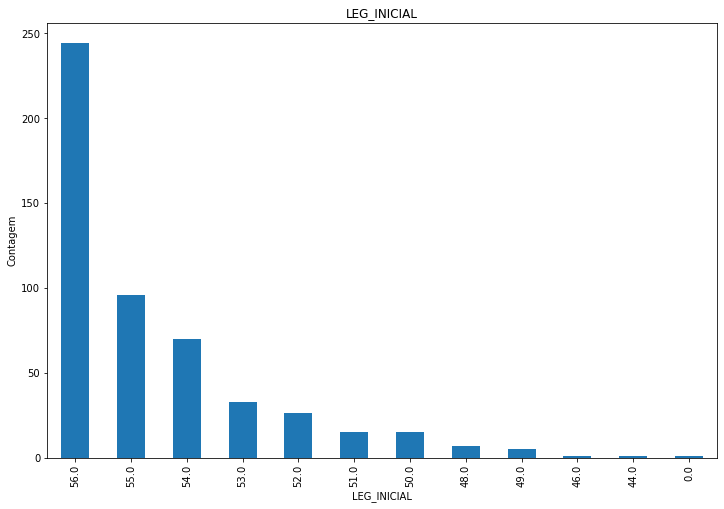

Text(0.5, 0, 'mandatos')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'mandatos')

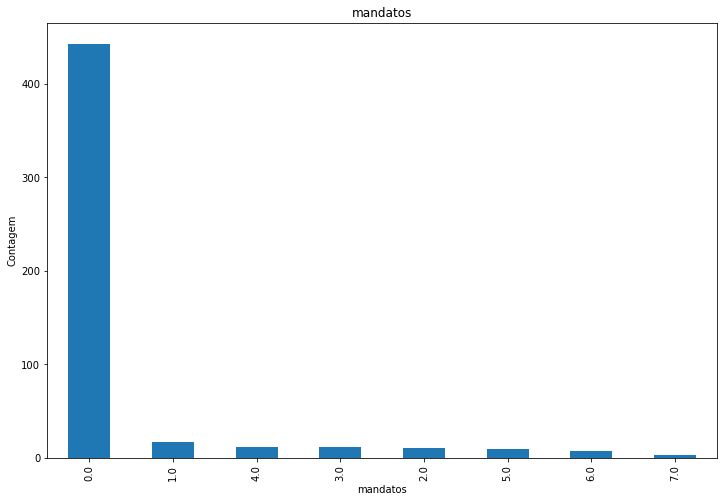

Text(0.5, 0, 'cabeças')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'cabeças')

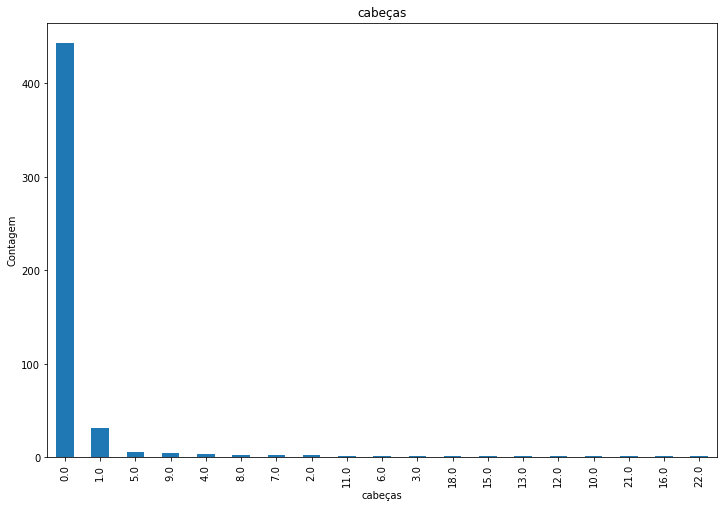

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'debatedor')

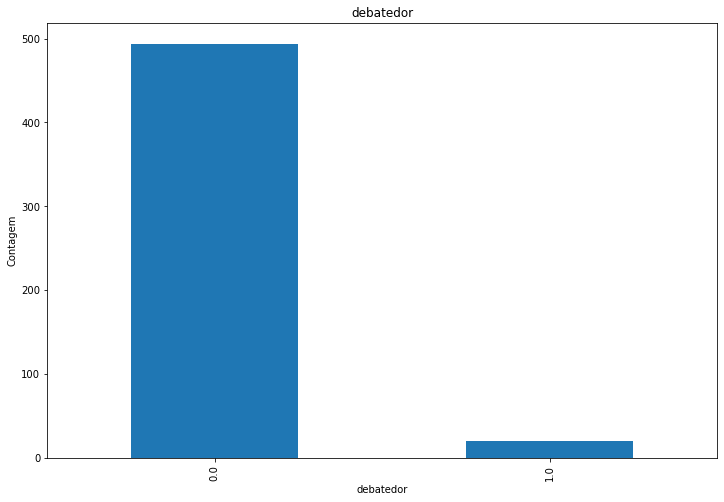

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'articulador')

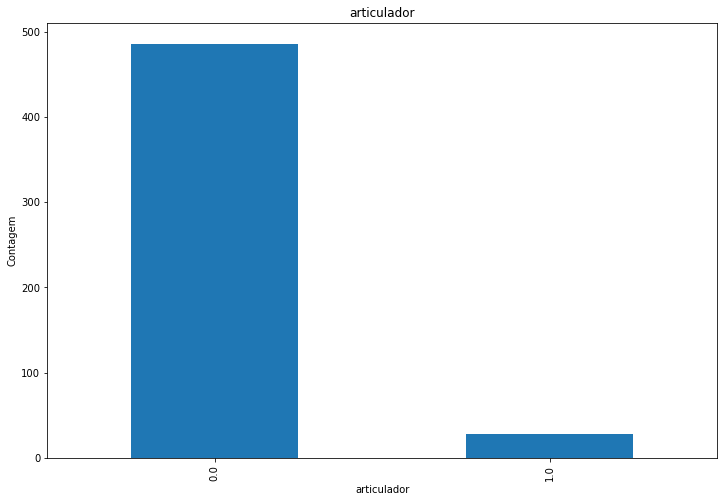

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'formulador')

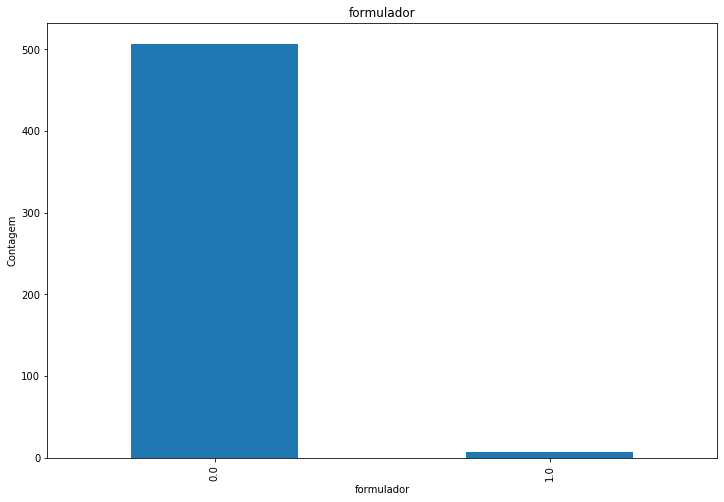

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'negociador')

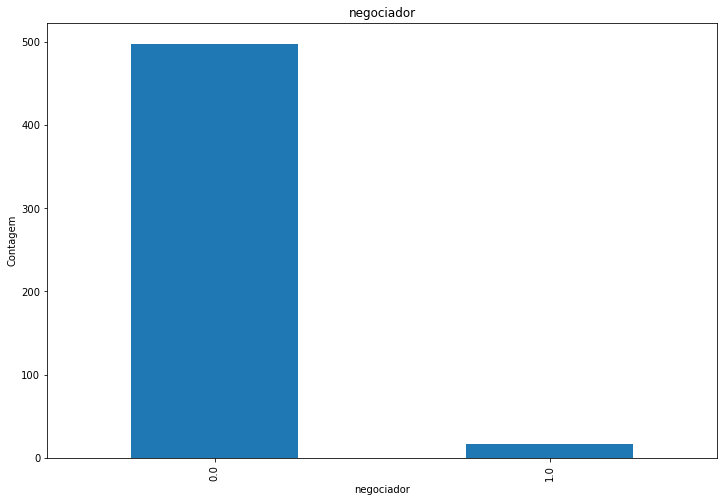

In [28]:
for variavel in variaveis_categoricas:
    df[variavel].value_counts().plot(kind="bar")
    plt.xlabel(variavel)
    plt.ylabel("Contagem")
    plt.title(variavel)
    plt.show()

### Boxplots - Identificando, verificando e tratando outliers


Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'DS_GENERO')

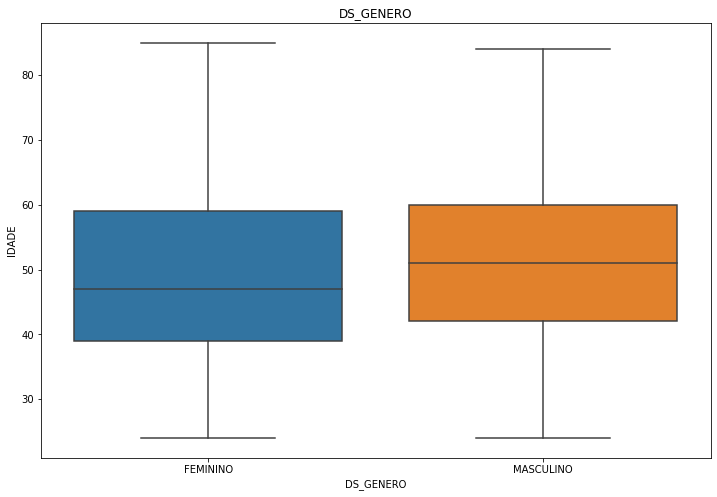

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'DS_GENERO')

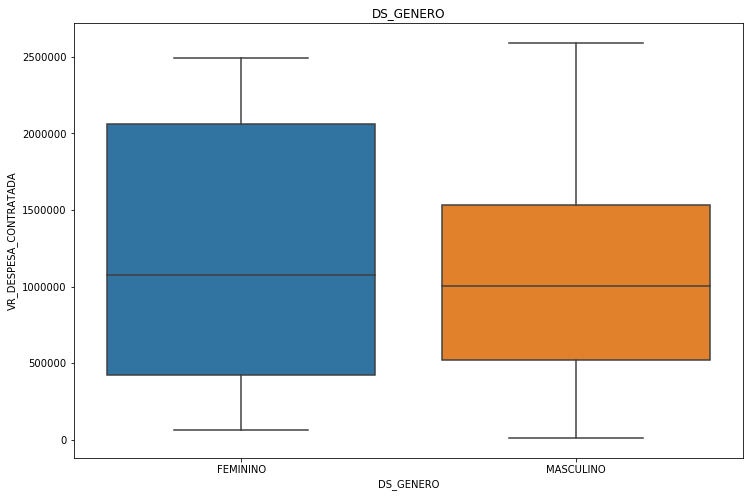

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'DS_GENERO')

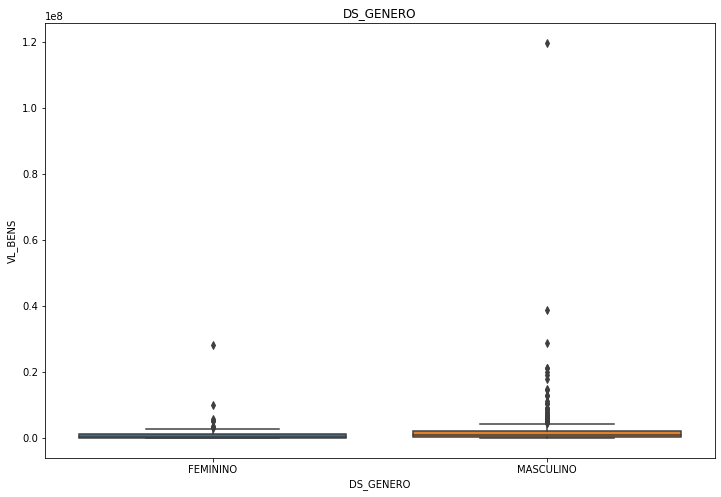

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

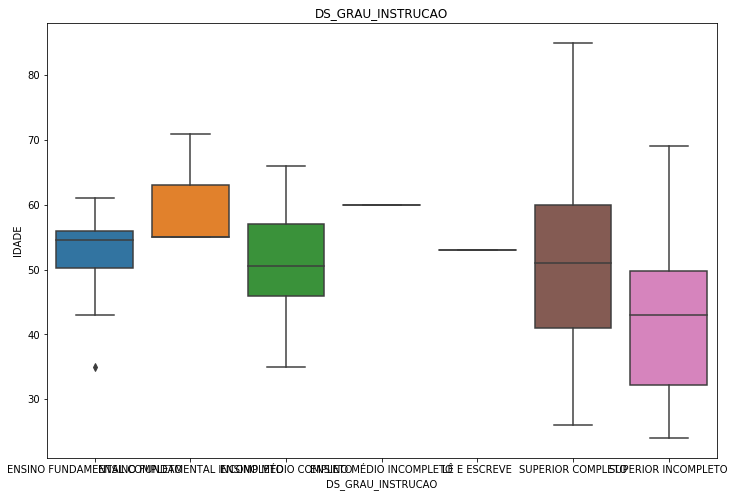

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

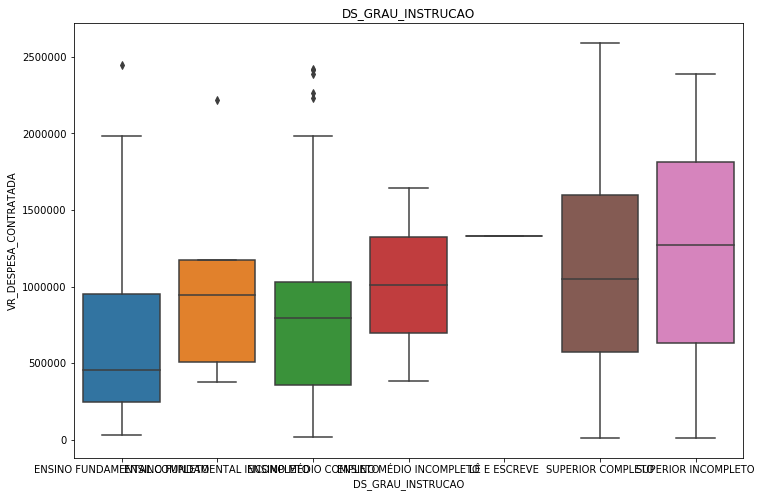

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

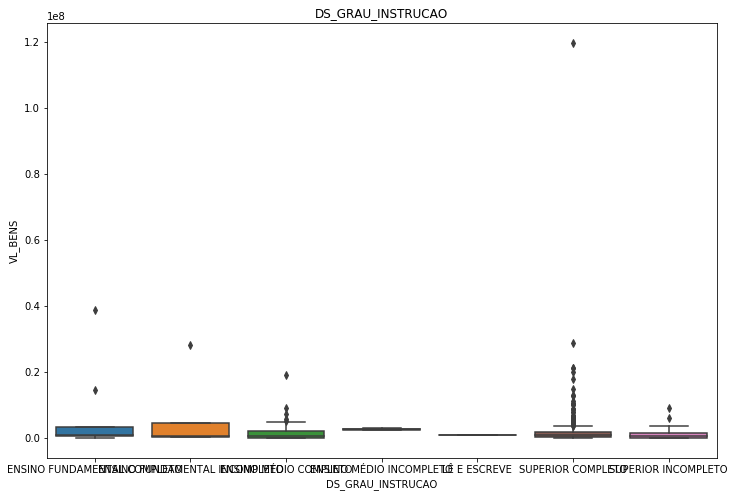

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

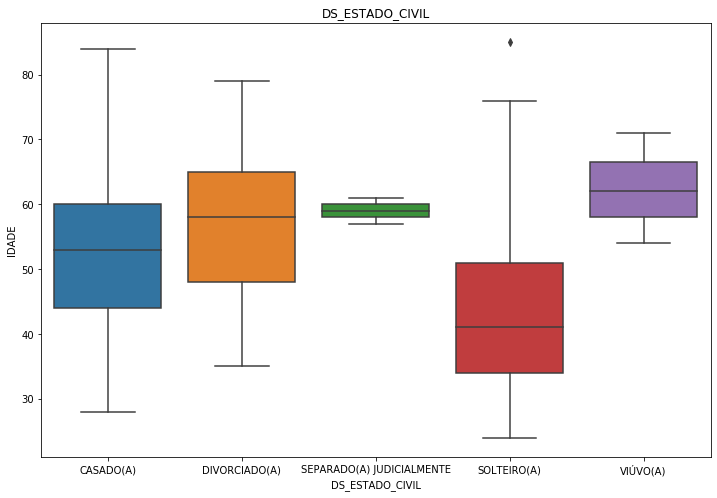

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

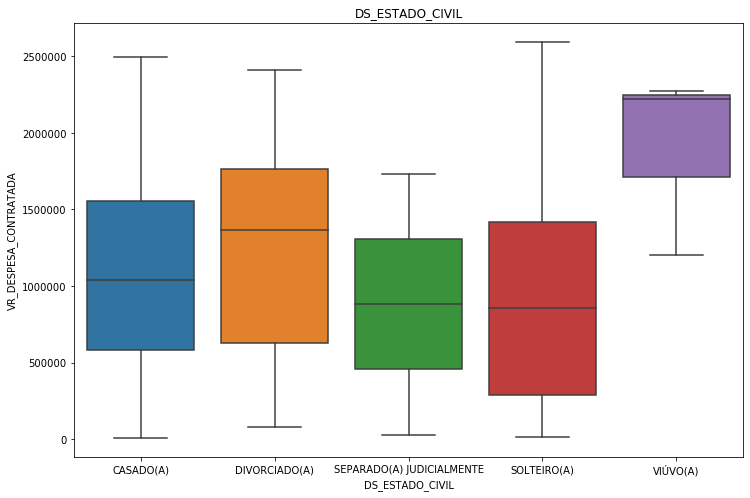

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

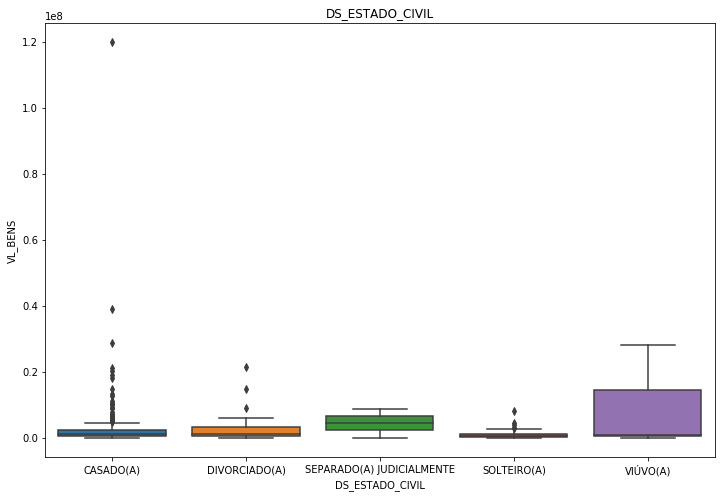

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

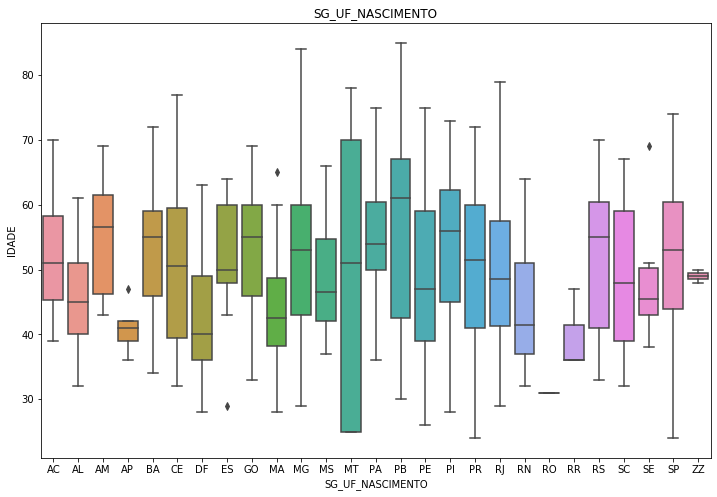

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

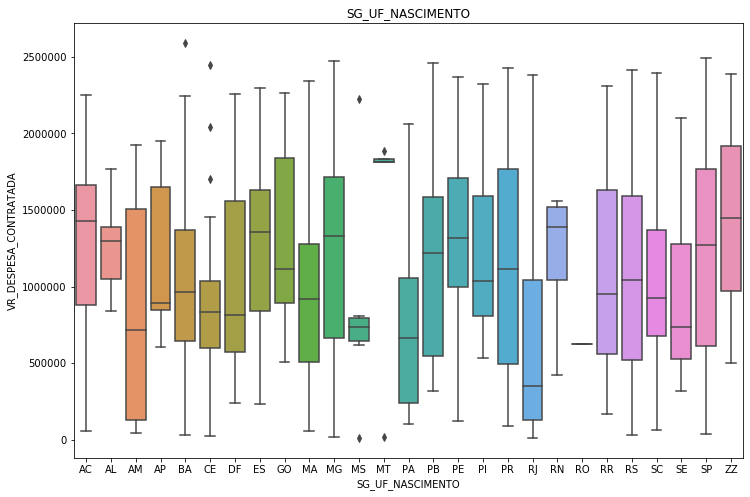

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

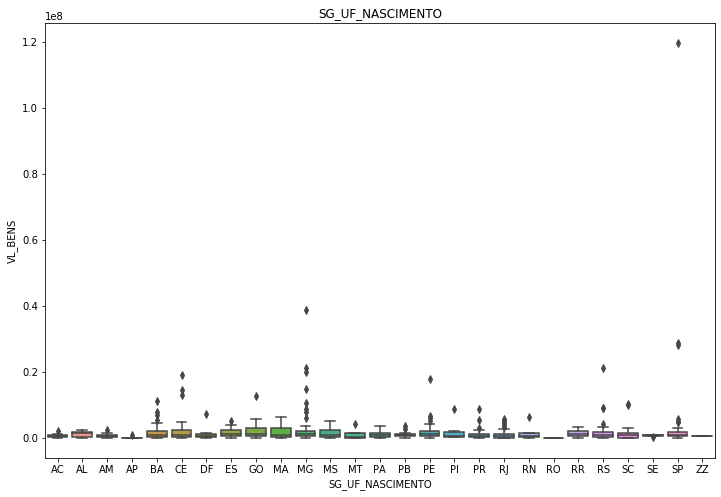

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'DS_COR_RACA')

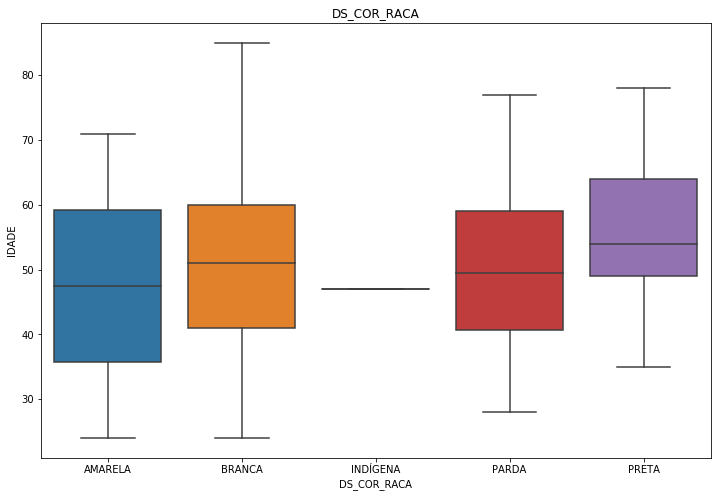

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'DS_COR_RACA')

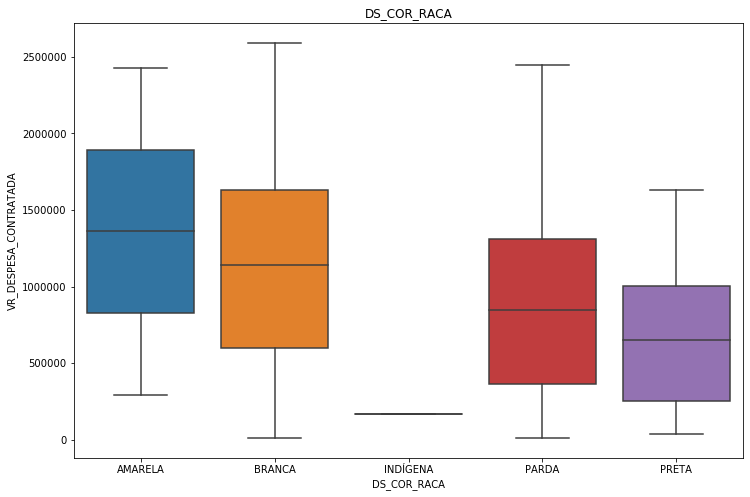

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'DS_COR_RACA')

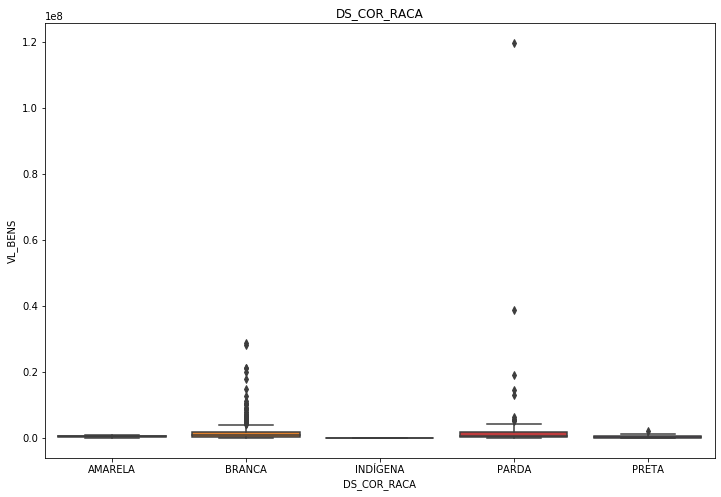

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'DS_OCUPACAO')

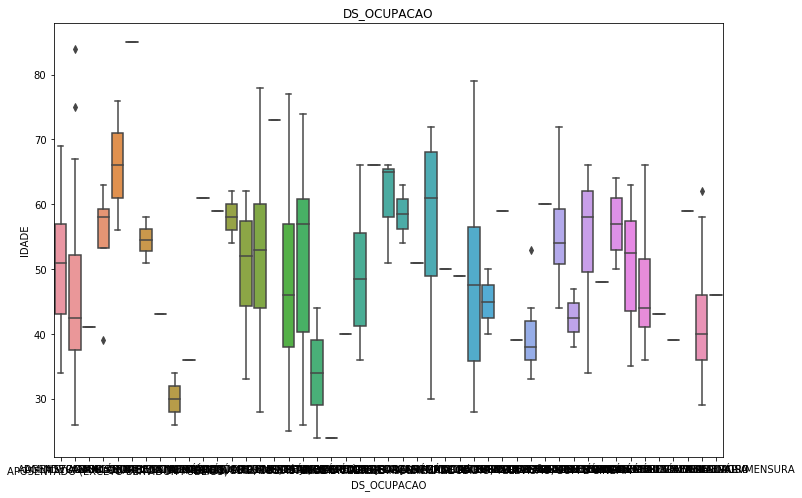

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'DS_OCUPACAO')

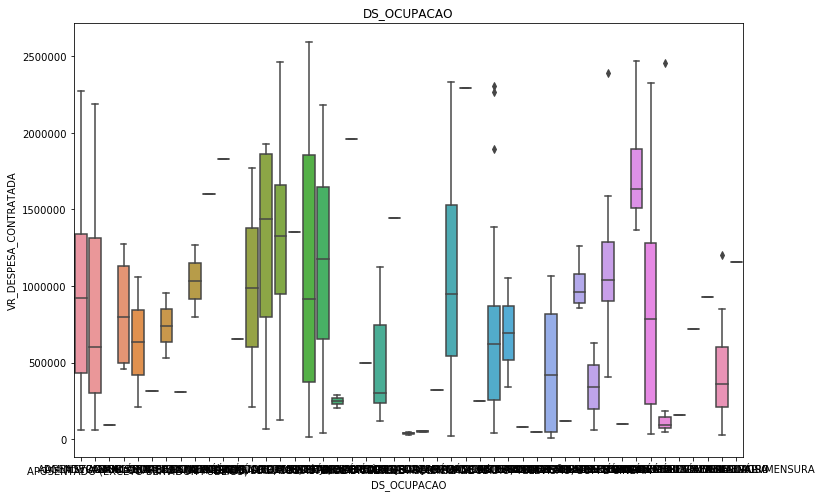

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'DS_OCUPACAO')

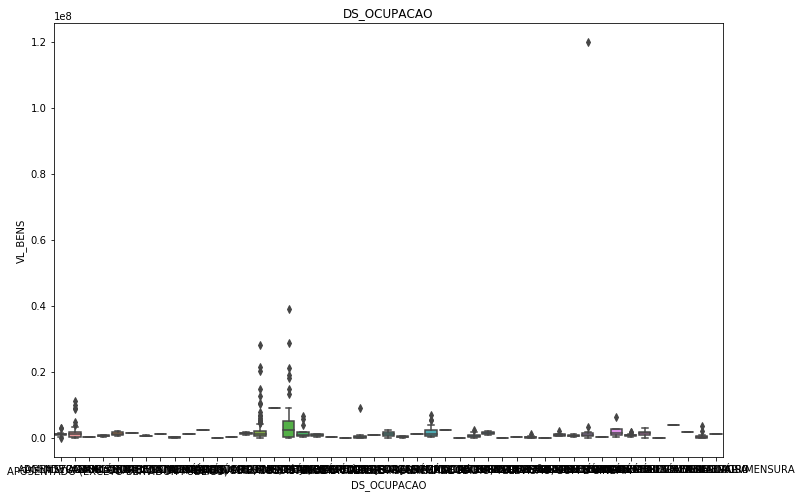

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'SG_PARTIDO')

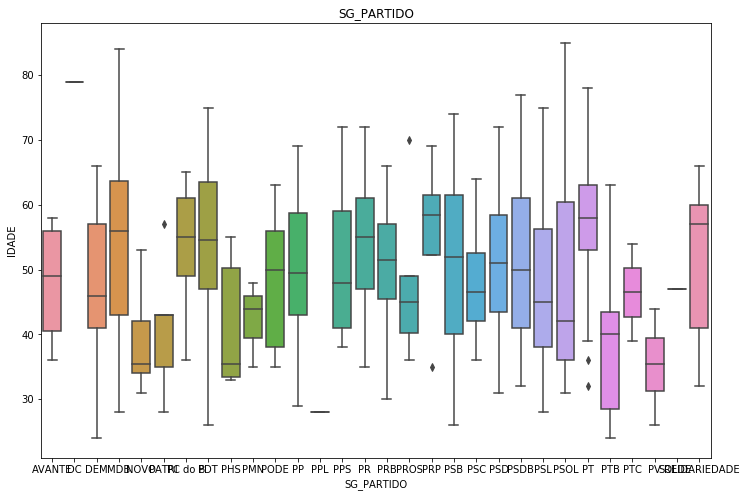

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'SG_PARTIDO')

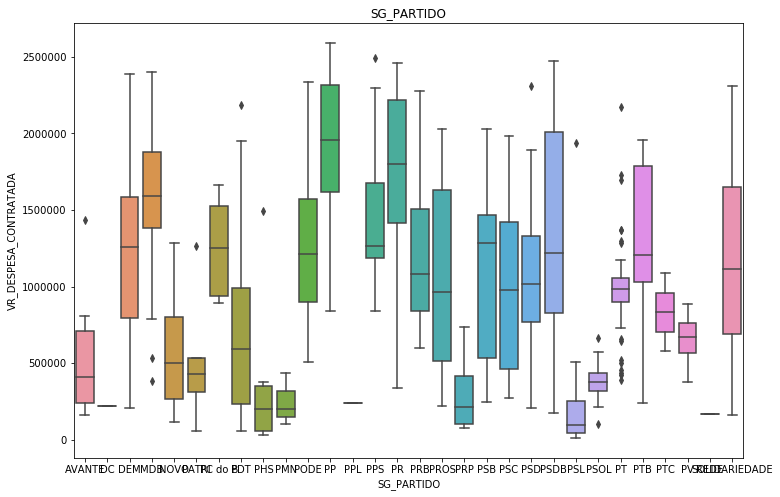

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'SG_PARTIDO')

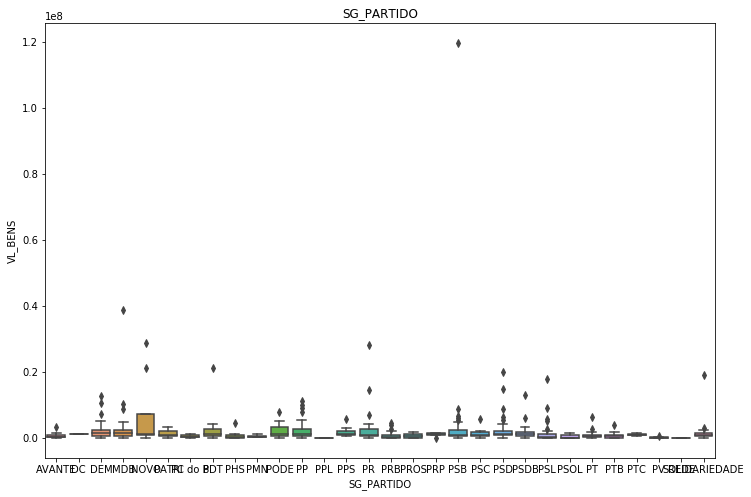

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'SG_UE')

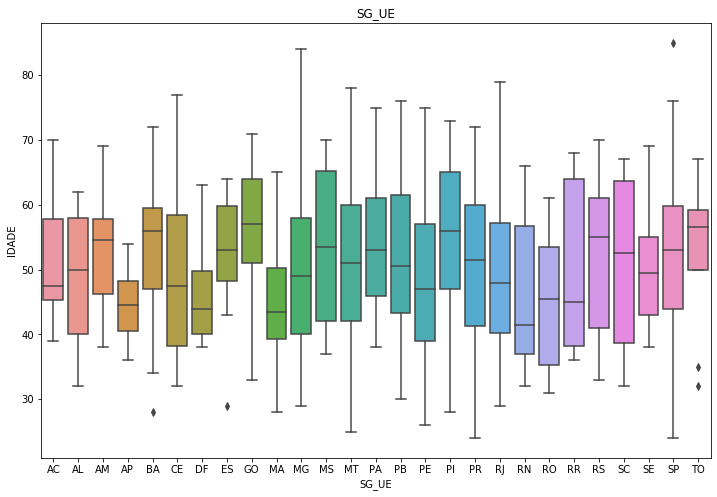

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'SG_UE')

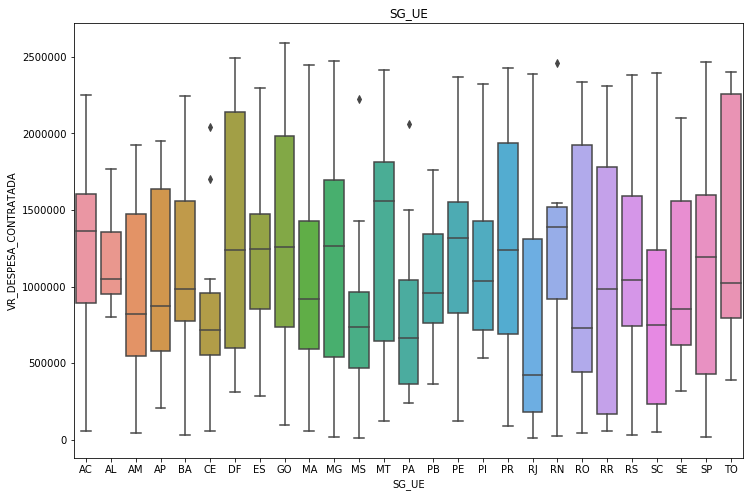

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'SG_UE')

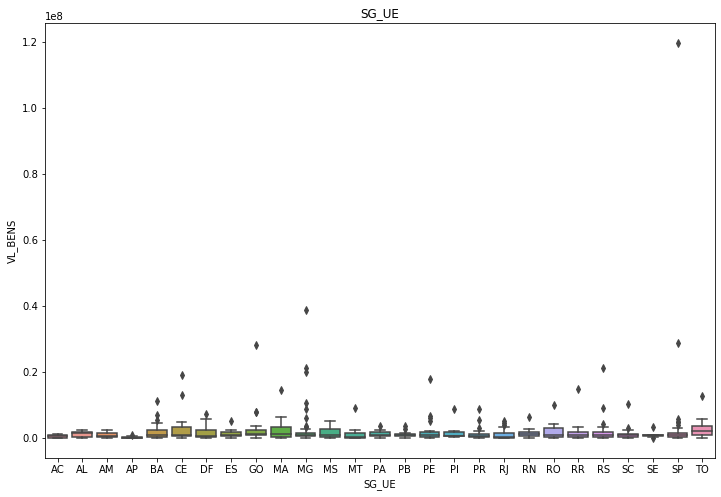

Text(0.5, 0, 'LEG_INICIAL')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'LEG_INICIAL')

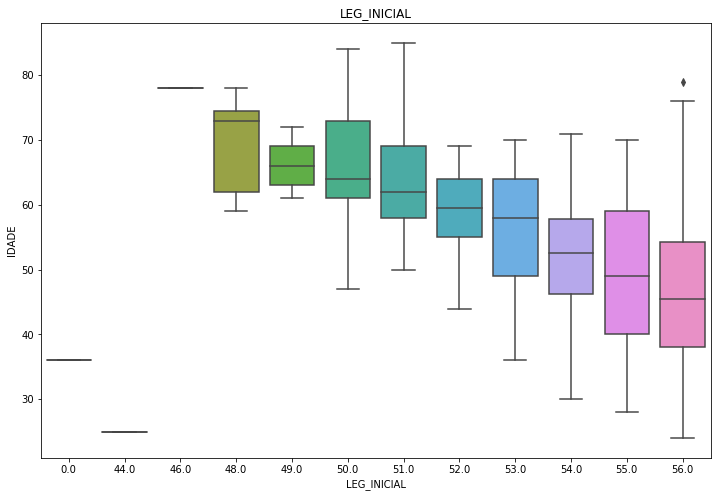

Text(0.5, 0, 'LEG_INICIAL')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'LEG_INICIAL')

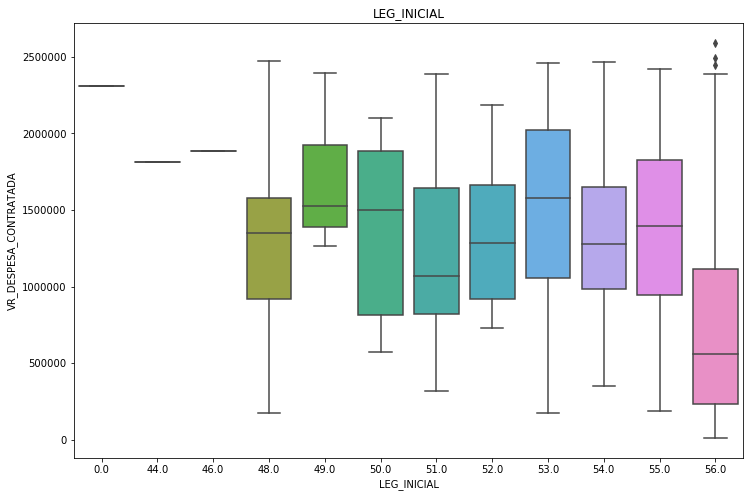

Text(0.5, 0, 'LEG_INICIAL')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'LEG_INICIAL')

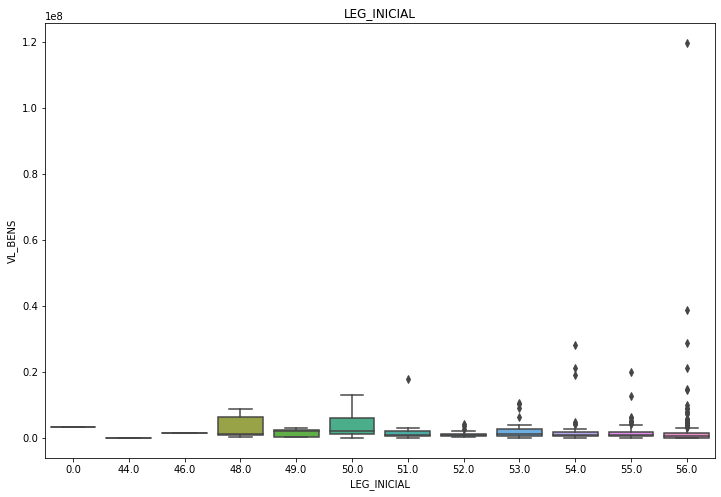

Text(0.5, 0, 'mandatos')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'mandatos')

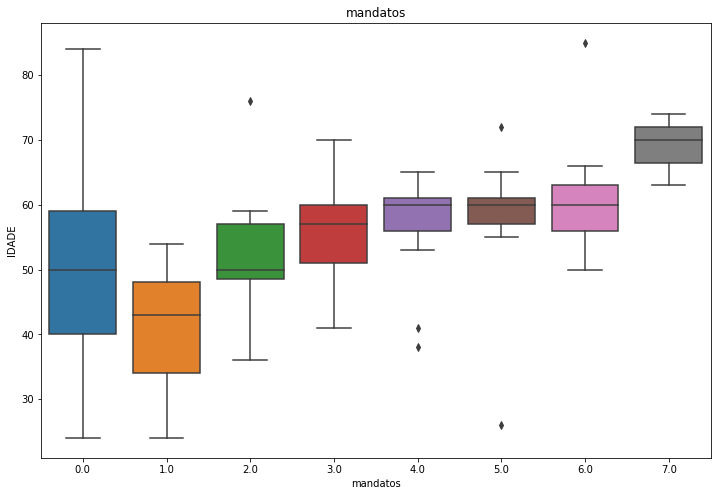

Text(0.5, 0, 'mandatos')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'mandatos')

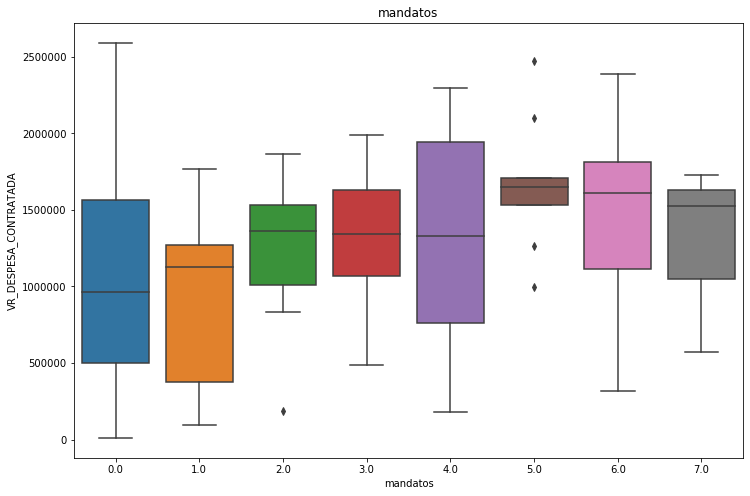

Text(0.5, 0, 'mandatos')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'mandatos')

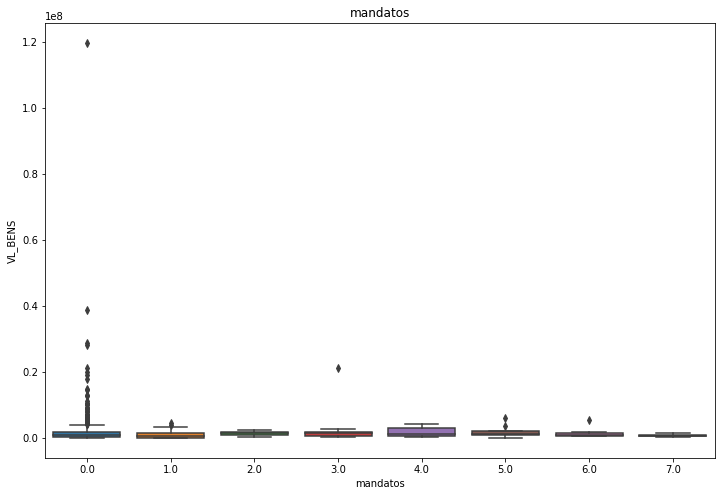

Text(0.5, 0, 'cabeças')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'cabeças')

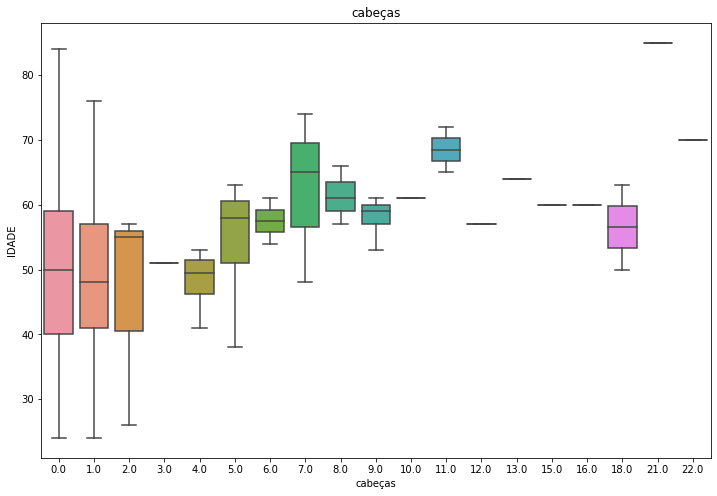

Text(0.5, 0, 'cabeças')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'cabeças')

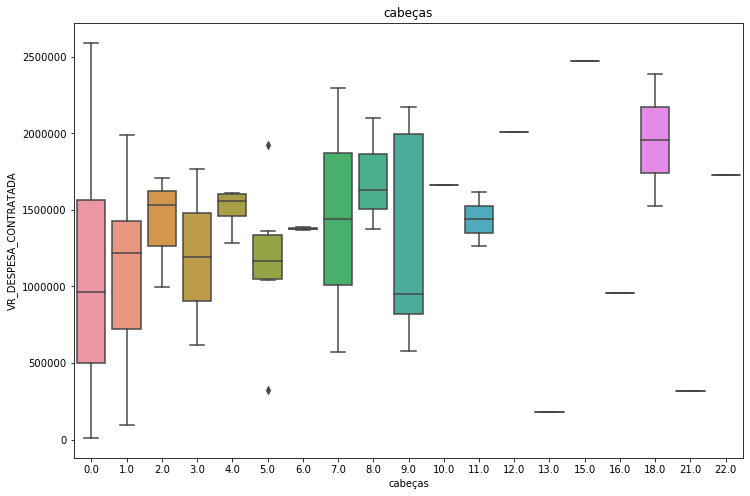

Text(0.5, 0, 'cabeças')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'cabeças')

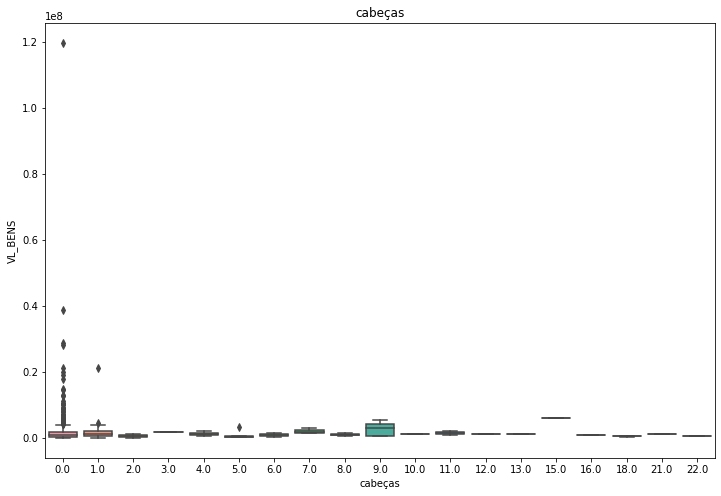

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'debatedor')

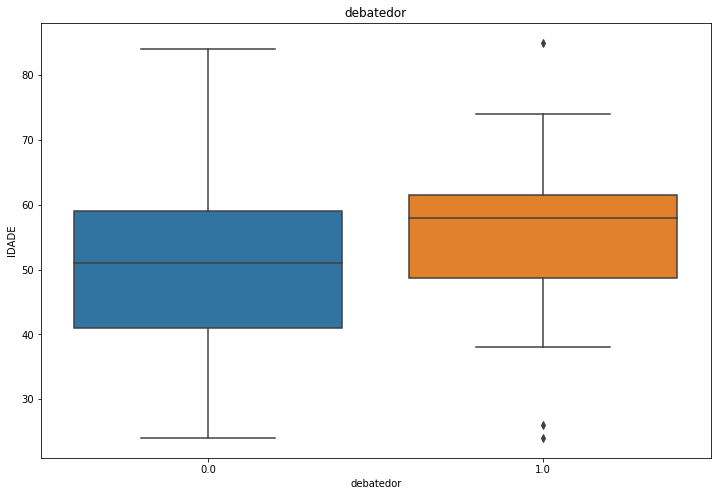

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'debatedor')

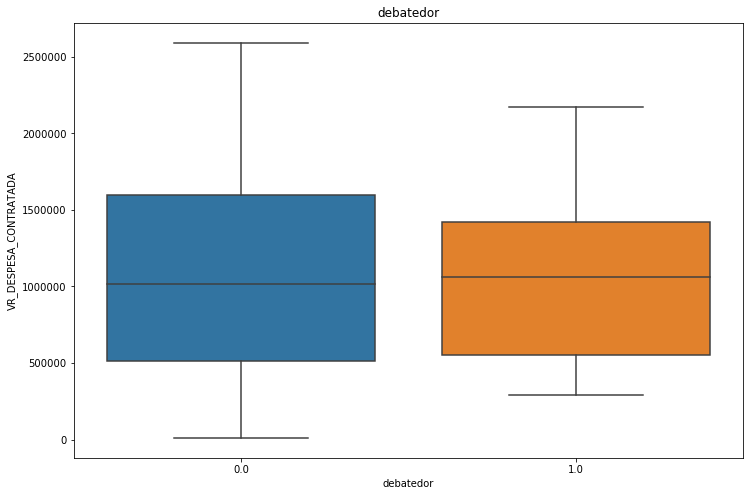

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'debatedor')

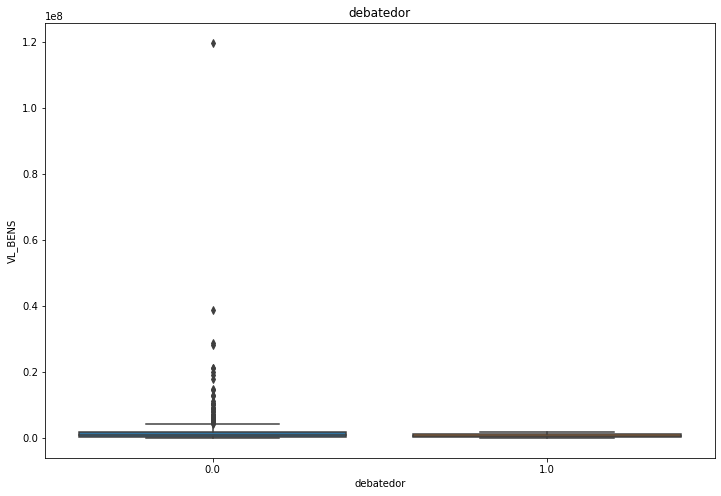

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'articulador')

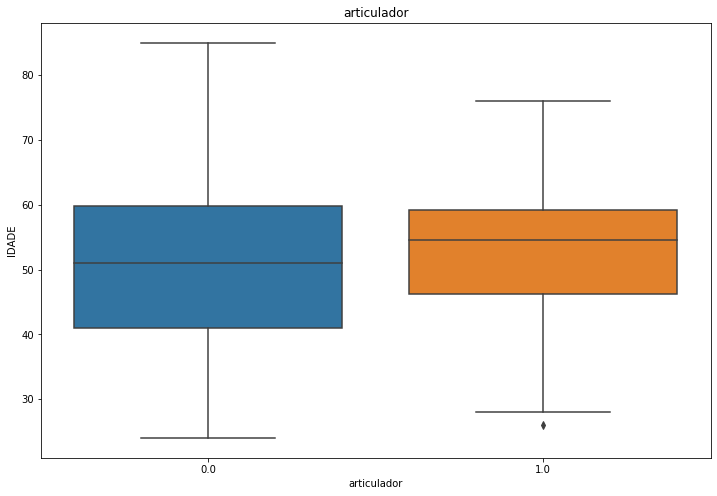

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'articulador')

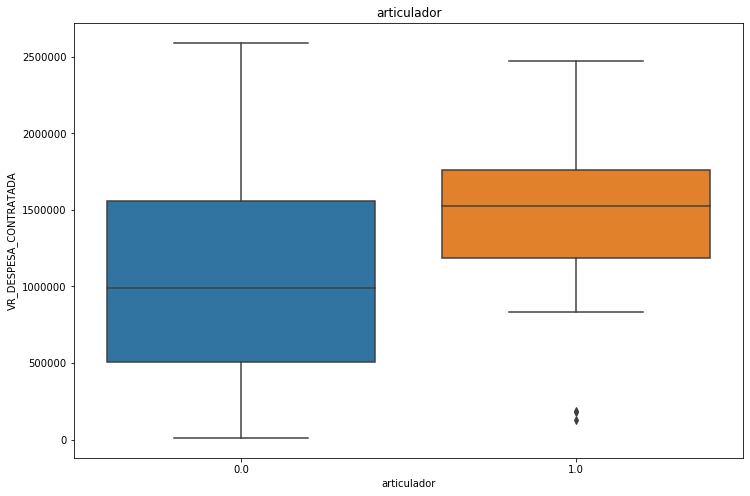

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'articulador')

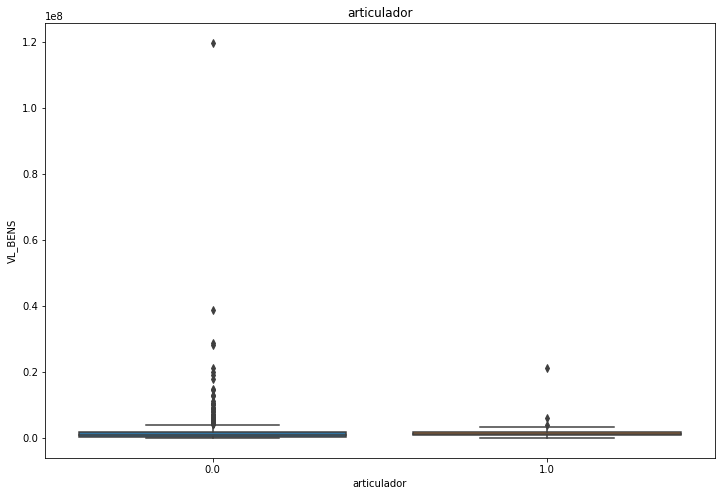

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'formulador')

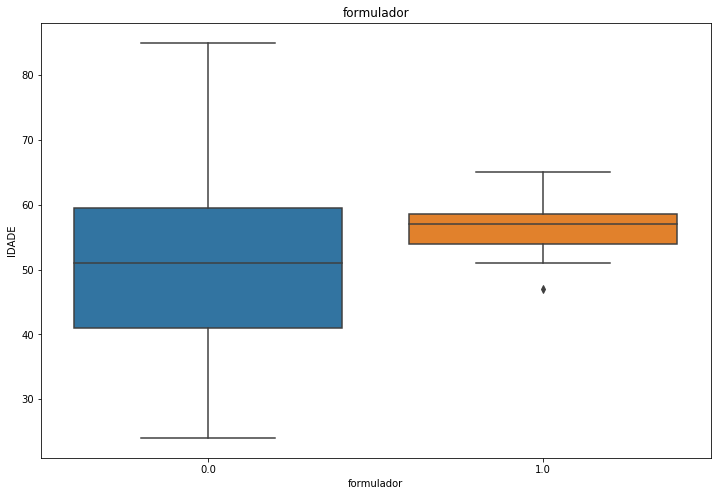

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'formulador')

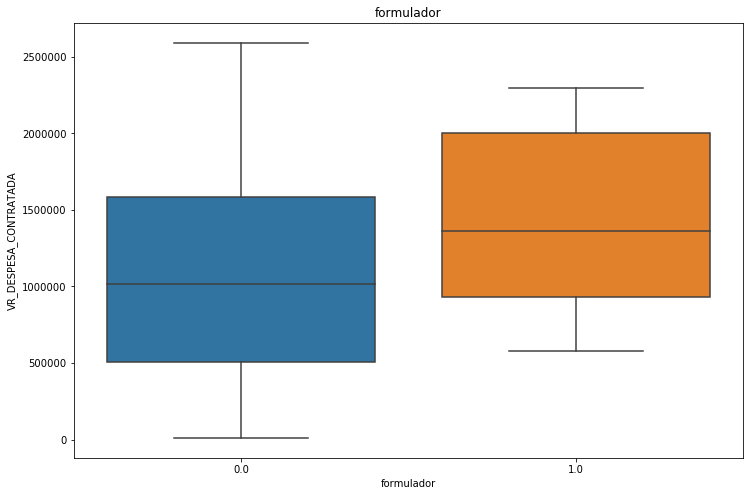

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'formulador')

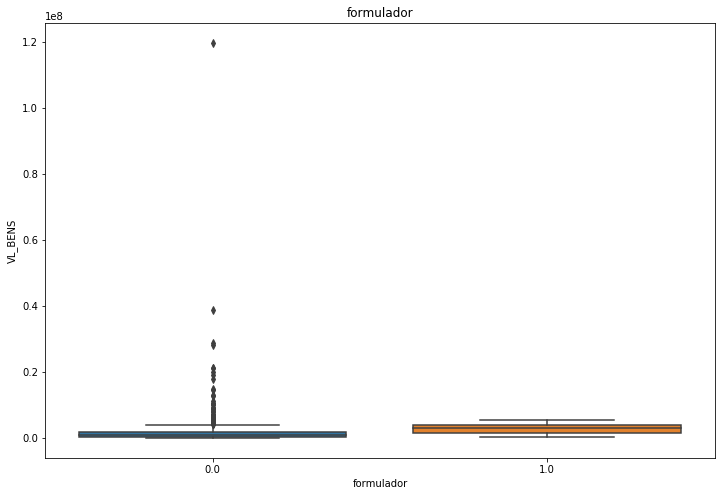

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'negociador')

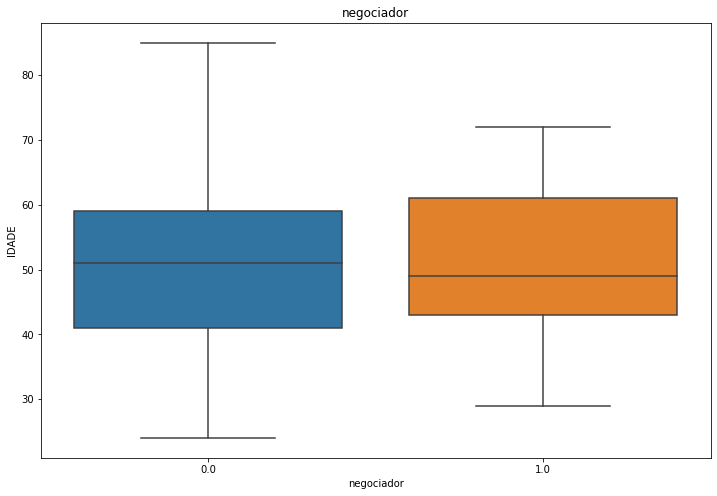

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'negociador')

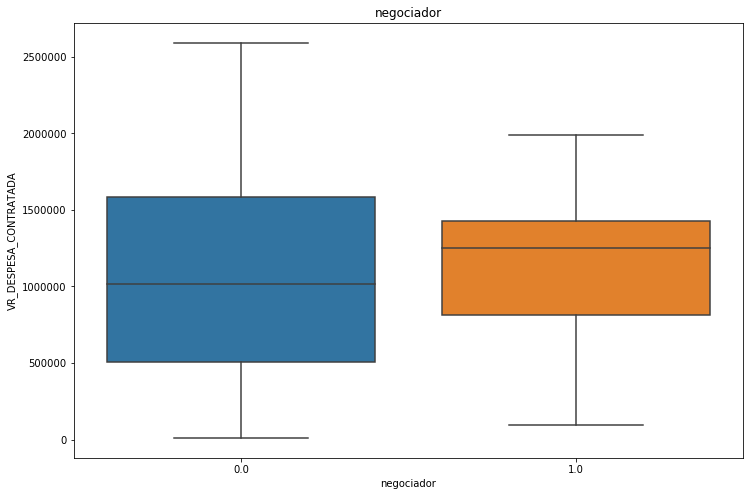

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'negociador')

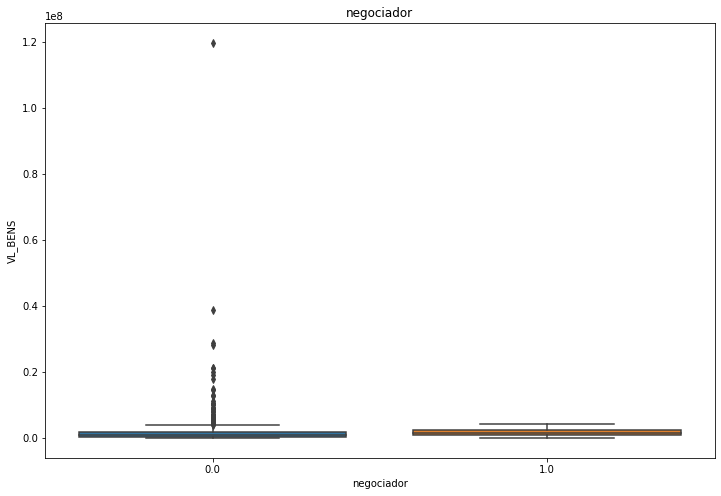

In [29]:
for cat in variaveis_categoricas:
    for num in variaveis_numericas:
        sns.boxplot(x=cat, y=num, data=df)
        plt.xlabel(cat)
        plt.ylabel(num)
        plt.title(cat)
        plt.show()


## Criação das variáveis dummies, categoricas e numéricas para modelo

In [30]:
#variaveis_categoricas.remove(target[0])
#variaveis_dummy.remove(target[0])
variaveis_mod_cat=variaveis_categoricas
variaveis_dummy=[]
variaveis_mod_cat

['DS_GENERO',
 'DS_GRAU_INSTRUCAO',
 'DS_ESTADO_CIVIL',
 'SG_UF_NASCIMENTO',
 'DS_COR_RACA',
 'DS_OCUPACAO',
 'SG_PARTIDO',
 'SG_UE',
 'LEG_INICIAL',
 'mandatos',
 'cabeças',
 'debatedor',
 'articulador',
 'formulador',
 'negociador']

In [31]:
variaveis_mod_cat.remove("SG_UF_NASCIMENTO")
variaveis_mod_cat.remove("SG_UE")
variaveis_mod_cat.remove("SG_PARTIDO")
variaveis_mod_cat.remove("LEG_INICIAL")
variaveis_mod_cat.remove("DS_OCUPACAO")
variaveis_mod_cat.remove("debatedor")
variaveis_mod_cat.remove("articulador")
variaveis_mod_cat.remove("formulador")
variaveis_mod_cat.remove("negociador")
variaveis_mod_cat.remove("cabeças")
variaveis_mod_cat.remove("mandatos")
variaveis_mod_cat

['DS_GENERO', 'DS_GRAU_INSTRUCAO', 'DS_ESTADO_CIVIL', 'DS_COR_RACA']

In [32]:
variaveis_mod_num=variaveis_numericas
variaveis_mod_num.append("mandatos")
variaveis_mod_num

['IDADE', 'VR_DESPESA_CONTRATADA', 'VL_BENS', 'mandatos']

In [33]:
df_original=df.copy()
variaveis_modelo=variaveis_mod_cat+variaveis_mod_num
df=df[variaveis_modelo].copy()

In [34]:
# Trata variaveis binárias (0-1)
#df_original=df.copy()
for variavel in variaveis_dummy:
    df=pd.concat([df, pd.get_dummies(df[variavel].astype(object), prefix=variavel, drop_first=True)], axis=1)
    df.drop(columns=[variavel], inplace=True)
df.sample(5)
df.columns

,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,DS_COR_RACA,IDADE,VR_DESPESA_CONTRATADA,VL_BENS,mandatos
20,MASCULINO,SUPERIOR COMPLETO,DIVORCIADO(A),BRANCA,47.0,2182071.18,3869709.13,0.0
110,MASCULINO,SUPERIOR COMPLETO,CASADO(A),PARDA,49.0,1634541.00,264762.09,0.0
14,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BRANCA,46.0,2308183.23,1131122.02,0.0
168,MASCULINO,SUPERIOR COMPLETO,DIVORCIADO(A),PARDA,68.0,1799236.12,437000.00,0.0
187,FEMININO,SUPERIOR COMPLETO,CASADO(A),BRANCA,47.0,1124296.94,624258.48,0.0


Index(['DS_GENERO', 'DS_GRAU_INSTRUCAO', 'DS_ESTADO_CIVIL', 'DS_COR_RACA',
       'IDADE', 'VR_DESPESA_CONTRATADA', 'VL_BENS', 'mandatos'],
      dtype='object')

In [35]:
#Trata variaveis 
#variaveis_categoricas=list(set(variaveis_categoricas)-set(variaveis_dummy))
for variavel in variaveis_mod_cat:
    df=pd.concat([df, pd.get_dummies(df[variavel].astype(object), prefix=variavel)], axis=1)
    df.drop(columns=[variavel], inplace=True)
#df.sample(5)
df.columns

Index(['IDADE', 'VR_DESPESA_CONTRATADA', 'VL_BENS', 'mandatos',
       'DS_GENERO_FEMININO', 'DS_GENERO_MASCULINO',
       'DS_GRAU_INSTRUCAO_ENSINO FUNDAMENTAL COMPLETO',
       'DS_GRAU_INSTRUCAO_ENSINO FUNDAMENTAL INCOMPLETO',
       'DS_GRAU_INSTRUCAO_ENSINO MÉDIO COMPLETO',
       'DS_GRAU_INSTRUCAO_ENSINO MÉDIO INCOMPLETO',
       'DS_GRAU_INSTRUCAO_LÊ E ESCREVE', 'DS_GRAU_INSTRUCAO_SUPERIOR COMPLETO',
       'DS_GRAU_INSTRUCAO_SUPERIOR INCOMPLETO', 'DS_ESTADO_CIVIL_CASADO(A)',
       'DS_ESTADO_CIVIL_DIVORCIADO(A)',
       'DS_ESTADO_CIVIL_SEPARADO(A) JUDICIALMENTE',
       'DS_ESTADO_CIVIL_SOLTEIRO(A)', 'DS_ESTADO_CIVIL_VIÚVO(A)',
       'DS_COR_RACA_AMARELA', 'DS_COR_RACA_BRANCA', 'DS_COR_RACA_INDÍGENA',
       'DS_COR_RACA_PARDA', 'DS_COR_RACA_PRETA'],
      dtype='object')

In [36]:
variaveis_modelo=list(df.columns)
target=[]
#preditores=list(set(preditores)-set(target))
variaveis_modelo
target


['IDADE',
 'VR_DESPESA_CONTRATADA',
 'VL_BENS',
 'mandatos',
 'DS_GENERO_FEMININO',
 'DS_GENERO_MASCULINO',
 'DS_GRAU_INSTRUCAO_ENSINO FUNDAMENTAL COMPLETO',
 'DS_GRAU_INSTRUCAO_ENSINO FUNDAMENTAL INCOMPLETO',
 'DS_GRAU_INSTRUCAO_ENSINO MÉDIO COMPLETO',
 'DS_GRAU_INSTRUCAO_ENSINO MÉDIO INCOMPLETO',
 'DS_GRAU_INSTRUCAO_LÊ E ESCREVE',
 'DS_GRAU_INSTRUCAO_SUPERIOR COMPLETO',
 'DS_GRAU_INSTRUCAO_SUPERIOR INCOMPLETO',
 'DS_ESTADO_CIVIL_CASADO(A)',
 'DS_ESTADO_CIVIL_DIVORCIADO(A)',
 'DS_ESTADO_CIVIL_SEPARADO(A) JUDICIALMENTE',
 'DS_ESTADO_CIVIL_SOLTEIRO(A)',
 'DS_ESTADO_CIVIL_VIÚVO(A)',
 'DS_COR_RACA_AMARELA',
 'DS_COR_RACA_BRANCA',
 'DS_COR_RACA_INDÍGENA',
 'DS_COR_RACA_PARDA',
 'DS_COR_RACA_PRETA']

[]

## Escala dos preditores

In [37]:
def verifica_escala(preditores,df):
    x=df[preditores].values
    plt.plot(x.min(axis=0),"o", label="min")
    plt.plot(x.max(axis=0),"^", label="max")
    plt.legend(loc="best")
    plt.xlabel("Feature index")
    plt.ylabel("Feature magnitude")
    plt.yscale("log")
    print(df[preditores].max().round(3))

IDADE                                              8.500000e+01
VR_DESPESA_CONTRATADA                              2.591858e+06
VL_BENS                                            1.198105e+08
mandatos                                           7.000000e+00
DS_GENERO_FEMININO                                 1.000000e+00
DS_GENERO_MASCULINO                                1.000000e+00
DS_GRAU_INSTRUCAO_ENSINO FUNDAMENTAL COMPLETO      1.000000e+00
DS_GRAU_INSTRUCAO_ENSINO FUNDAMENTAL INCOMPLETO    1.000000e+00
DS_GRAU_INSTRUCAO_ENSINO MÉDIO COMPLETO            1.000000e+00
DS_GRAU_INSTRUCAO_ENSINO MÉDIO INCOMPLETO          1.000000e+00
DS_GRAU_INSTRUCAO_LÊ E ESCREVE                     1.000000e+00
DS_GRAU_INSTRUCAO_SUPERIOR COMPLETO                1.000000e+00
DS_GRAU_INSTRUCAO_SUPERIOR INCOMPLETO              1.000000e+00
DS_ESTADO_CIVIL_CASADO(A)                          1.000000e+00
DS_ESTADO_CIVIL_DIVORCIADO(A)                      1.000000e+00
DS_ESTADO_CIVIL_SEPARADO(A) JUDICIALMENT

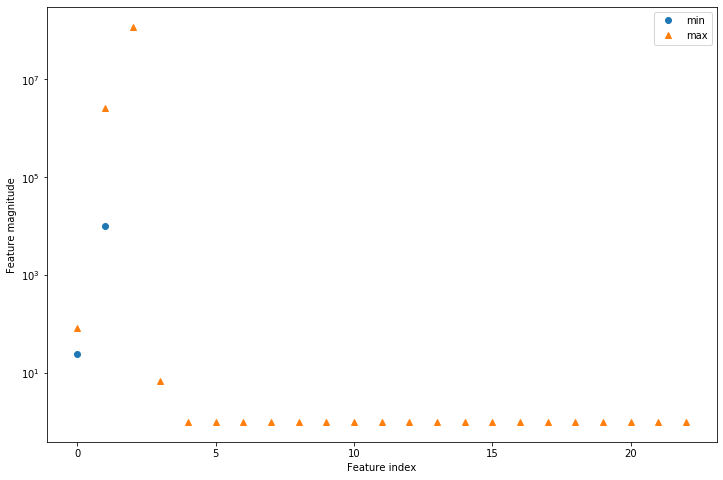

In [38]:
verifica_escala(variaveis_modelo,df)

In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[variaveis_modelo].values)
x=scaler.transform(df[variaveis_modelo].values)
df_scaled=pd.DataFrame(x,columns=variaveis_modelo)
df_scaled.head()
#df_original=df.copy()
df=df_scaled.copy()

MinMaxScaler()

,IDADE,VR_DESPESA_CONTRATADA,VL_BENS,mandatos,DS_GENERO_FEMININO,DS_GENERO_MASCULINO,DS_GRAU_INSTRUCAO_ENSINO FUNDAMENTAL COMPLETO,DS_GRAU_INSTRUCAO_ENSINO FUNDAMENTAL INCOMPLETO,DS_GRAU_INSTRUCAO_ENSINO MÉDIO COMPLETO,DS_GRAU_INSTRUCAO_ENSINO MÉDIO INCOMPLETO,...,DS_ESTADO_CIVIL_CASADO(A),DS_ESTADO_CIVIL_DIVORCIADO(A),DS_ESTADO_CIVIL_SEPARADO(A) JUDICIALMENTE,DS_ESTADO_CIVIL_SOLTEIRO(A),DS_ESTADO_CIVIL_VIÚVO(A),DS_COR_RACA_AMARELA,DS_COR_RACA_BRANCA,DS_COR_RACA_INDÍGENA,DS_COR_RACA_PARDA,DS_COR_RACA_PRETA
0,0.491803,0.016535,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.147541,0.917967,0.007987,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.442623,0.075465,0.004765,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.557377,0.236230,0.003346,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.442623,0.137308,0.007011,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 23 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   IDADE                                            514 non-null    float64
 1   VR_DESPESA_CONTRATADA                            514 non-null    float64
 2   VL_BENS                                          514 non-null    float64
 3   mandatos                                         514 non-null    float64
 4   DS_GENERO_FEMININO                               514 non-null    float64
 5   DS_GENERO_MASCULINO                              514 non-null    float64
 6   DS_GRAU_INSTRUCAO_ENSINO FUNDAMENTAL COMPLETO    514 non-null    float64
 7   DS_GRAU_INSTRUCAO_ENSINO FUNDAMENTAL INCOMPLETO  514 non-null    float64
 8   DS_GRAU_INSTRUCAO_ENSINO MÉDIO COMPLETO          514 non-null    float64
 9   DS_GRAU_INSTRUCAO_ENSINO MÉDIO I

## Visualizando com PCA

In [41]:
x=df.values
variaveis=list(df.columns)

In [42]:
from sklearn.decomposition import PCA
# keep the first two principal components of the data
pca = PCA(n_components=3)
# fit PCA model 
pca.fit(x)
# transform data onto the first two principal components
x_pca = pca.transform(x)
print("Original shape: {}".format(str(x.shape)))
print("Reduced shape: {}".format(str(x_pca.shape)))
df_pca=pd.DataFrame(x_pca,columns=["PC-1","PC-2","PC-3"])

PCA(n_components=3)

Original shape: (514, 23)
Reduced shape: (514, 3)


Text(0.5, 0, 'First principal component')

Text(0.5, 0, 'Second principal component')

Text(0.5, 0, 'third principal component')

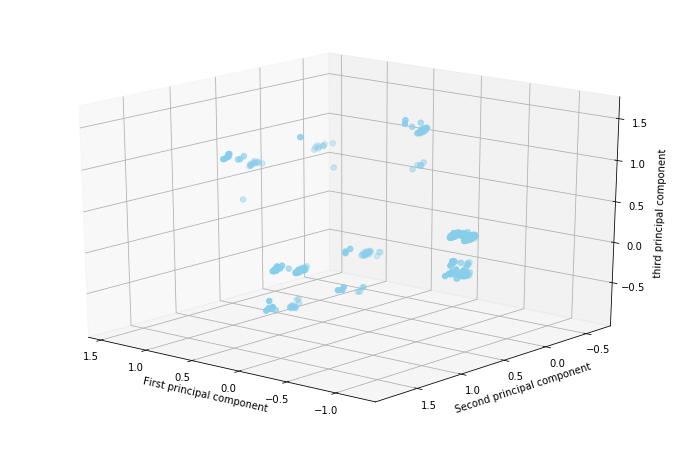

In [44]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca['PC-1'], df_pca['PC-2'], df_pca['PC-3'], c='skyblue', s=30)
ax.set_xlabel("First principal component")
ax.set_ylabel("Second principal component")
ax.set_zlabel("third principal component")
ax.view_init(20, 130)
plt.show()

PCA component shape: (3, 23)


,IDADE,VR_DESPESA_CONTRATADA,VL_BENS,mandatos,DS_GENERO_FEMININO,DS_GENERO_MASCULINO,DS_GRAU_INSTRUCAO_ENSINO FUNDAMENTAL COMPLETO,DS_GRAU_INSTRUCAO_ENSINO FUNDAMENTAL INCOMPLETO,DS_GRAU_INSTRUCAO_ENSINO MÉDIO COMPLETO,DS_GRAU_INSTRUCAO_ENSINO MÉDIO INCOMPLETO,...,DS_ESTADO_CIVIL_CASADO(A),DS_ESTADO_CIVIL_DIVORCIADO(A),DS_ESTADO_CIVIL_SEPARADO(A) JUDICIALMENTE,DS_ESTADO_CIVIL_SOLTEIRO(A),DS_ESTADO_CIVIL_VIÚVO(A),DS_COR_RACA_AMARELA,DS_COR_RACA_BRANCA,DS_COR_RACA_INDÍGENA,DS_COR_RACA_PARDA,DS_COR_RACA_PRETA
0,-0.064320,0.043150,-0.009673,0.008515,0.272859,-0.272859,-0.024330,-0.006857,-0.121505,-0.007497,...,-0.562824,0.101589,0.004375,0.445111,0.011749,-0.001214,0.389793,0.000003,-0.347349,-0.041233
1,-0.074922,-0.095994,-0.001595,-0.036637,-0.022114,0.022114,0.031966,-0.000481,0.135210,0.002331,...,-0.458012,0.043419,-0.000696,0.416293,-0.001004,0.006530,-0.533520,0.000057,0.489402,0.037530
2,0.028954,0.032256,0.001255,-0.015560,0.605615,-0.605615,-0.016377,-0.001865,-0.061599,-0.001647,...,0.189338,-0.011855,-0.005351,-0.182484,0.010352,-0.003661,-0.273148,0.010730,0.227783,0.038296


<Figure size 864x144 with 0 Axes>

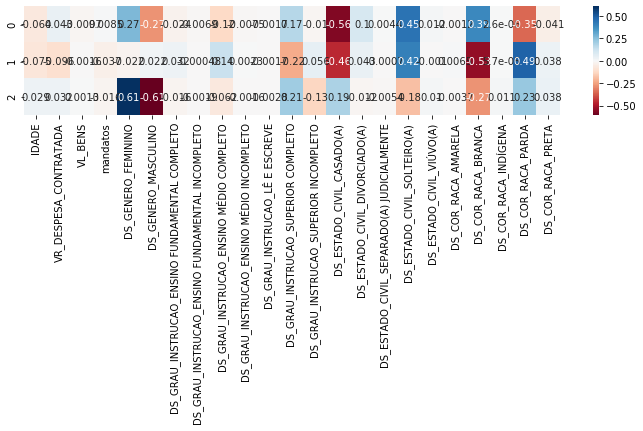

In [45]:
df_pca_componentes=pd.DataFrame(pca.components_, columns=variaveis)
print("PCA component shape: {}".format(df_pca_componentes.shape))
df_pca_componentes
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")
#(correlação,annot=True, vmin=-1, vmax=1)

In [53]:
def plot_pca_2d(x,y=True):
    plt.figure(figsize=(8, 8))
    if y.all():
        plt.scatter(x[:, 0], x[:, 1])
        plt.gca().set_aspect("equal")
    else:
        clusters = unique(y)
        for cluster in clusters:
            row_ix = where(y == cluster)
            # create scatter of these samples
            plt.scatter(x[row_ix, 0], x[row_ix, 1])
    plt.xlabel("First principal component")
    plt.ylabel("Second principal component")
    plt.legend(clusters, loc="best")
    plt.show()
    if clusters[0]==-1:
        quant=np.bincount(y+1)
    else:
        quant=np.bincount(y)
    frame=pd.DataFrame({"cluster":clusters,"quant":quant})
    print("Número de componentes \n{}".format(frame))
    

In [81]:
def plot_pca_3d(x,y=True):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if y.all():
        ax.scatter(x[:, 0], x[:, 1],x[:,2])
        ax.gca().set_aspect("equal")
    else:
        clusters = unique(y)
        for cluster in clusters:
            row_ix = where(y == cluster)
            # create scatter of these samples
            ax.scatter(x[row_ix, 0], x[row_ix, 1],x[row_ix, 2], s=20)
    ax.set_xlabel("PC-1")
    ax.set_ylabel("PC-2")
    ax.set_zlabel("PC-3")
    ax.legend(clusters, loc='upper left')
    ax.view_init(35, 120)
    plt.show()
    if clusters[0]==-1:
        quant=np.bincount(y+1)
    else:
        quant=np.bincount(y)
    frame=pd.DataFrame({"cluster":clusters,"quant":quant})
    print("Número de componentes \n{}".format(frame))
    

## ajustando variáveis

In [49]:
x=df.values

## K-mean


## Verificando o número de clusters via inércia

range(1, 50)

KMeans(n_clusters=1)

KMeans(n_clusters=2)

KMeans(n_clusters=3)

KMeans(n_clusters=4)

KMeans(n_clusters=5)

KMeans(n_clusters=6)

KMeans(n_clusters=7)

KMeans()

KMeans(n_clusters=9)

KMeans(n_clusters=10)

KMeans(n_clusters=11)

KMeans(n_clusters=12)

KMeans(n_clusters=13)

KMeans(n_clusters=14)

KMeans(n_clusters=15)

KMeans(n_clusters=16)

KMeans(n_clusters=17)

KMeans(n_clusters=18)

KMeans(n_clusters=19)

KMeans(n_clusters=20)

KMeans(n_clusters=21)

KMeans(n_clusters=22)

KMeans(n_clusters=23)

KMeans(n_clusters=24)

KMeans(n_clusters=25)

KMeans(n_clusters=26)

KMeans(n_clusters=27)

KMeans(n_clusters=28)

KMeans(n_clusters=29)

KMeans(n_clusters=30)

KMeans(n_clusters=31)

KMeans(n_clusters=32)

KMeans(n_clusters=33)

KMeans(n_clusters=34)

KMeans(n_clusters=35)

KMeans(n_clusters=36)

KMeans(n_clusters=37)

KMeans(n_clusters=38)

KMeans(n_clusters=39)

KMeans(n_clusters=40)

KMeans(n_clusters=41)

KMeans(n_clusters=42)

KMeans(n_clusters=43)

KMeans(n_clusters=44)

KMeans(n_clusters=45)

KMeans(n_clusters=46)

KMeans(n_clusters=47)

KMeans(n_clusters=48)

KMeans(n_clusters=49)

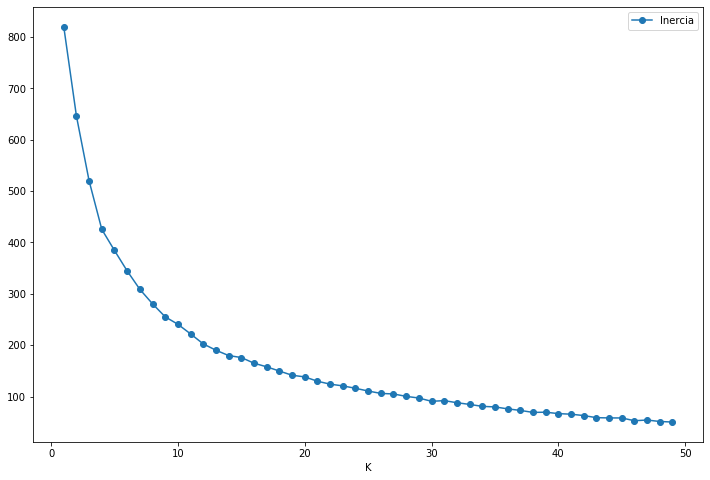

In [50]:
kvalues=range(1,50)
kvalues
inercia=[]
for k in kvalues:
    modelo=KMeans(n_clusters=k, init='k-means++')
    modelo.fit(x)
    inercia.append(modelo.inertia_)
df_inercia=pd.DataFrame({"Inercia":inercia, "K":kvalues}) 
df_inercia.plot("K","Inercia", marker='o')

In [55]:
# defining the kmeans function with initialization as k-means++
modelo = KMeans(n_clusters=10, init='k-means++')

# fitting the k means algorithm on scaled data
modelo.fit(x)
yhat = modelo.predict(x)
clusters = unique(yhat)
#print(variaveis_modelo)


KMeans(n_clusters=10)

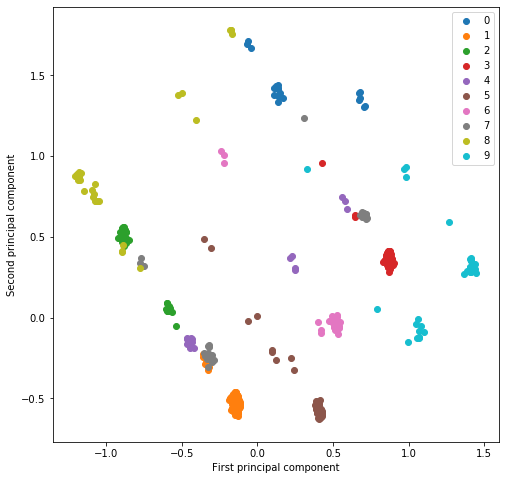

Número de componentes 
   cluster  quant
0        0     21
1        1    199
2        2     58
3        3     56
4        4     18
5        5     43
6        6     28
7        7     30
8        8     33
9        9     28


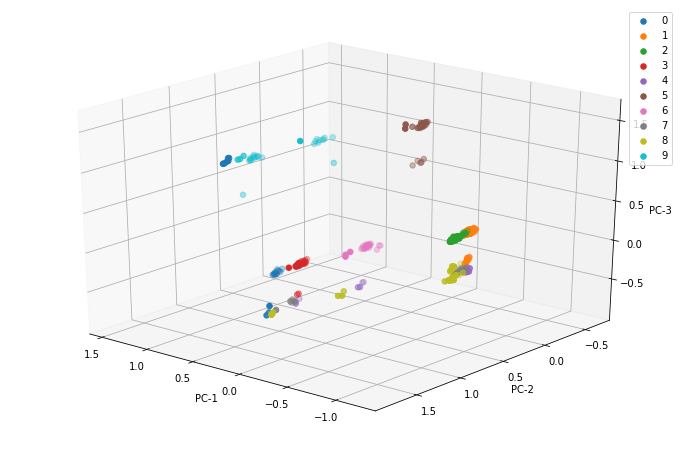

Número de componentes 
   cluster  quant
0        0     21
1        1    199
2        2     58
3        3     56
4        4     18
5        5     43
6        6     28
7        7     30
8        8     33
9        9     28


In [56]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)

In [57]:
df_kmeans=df_original.copy()
df_kmeans["cluster"]=yhat
df_kmeans.sample(5)

,CPF,NM_PUBLICO,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,SG_UF_NASCIMENTO,IDADE,DS_COR_RACA,DS_OCUPACAO,VL_BENS,...,SG_UE,VR_DESPESA_CONTRATADA,LEG_INICIAL,mandatos,cabeças,debatedor,articulador,formulador,negociador,cluster
124,58065083234,Jesus Sérgio,MASCULINO,SUPERIOR COMPLETO,CASADO(A),AC,47.0,PARDA,PROFESSOR DE ENSINO MÉDIO,1100000.00,...,AC,57134.70,56.0,0.0,0.0,0.0,0.0,0.0,0.0,2
183,83035605653,Rodrigo de Castro,MASCULINO,SUPERIOR COMPLETO,CASADO(A),MG,49.0,BRANCA,DEPUTADO,1664606.19,...,MG,1717766.29,53.0,0.0,0.0,0.0,0.0,0.0,0.0,1
512,03098871946,Zeca Dirceu,MASCULINO,SUPERIOR COMPLETO,SOLTEIRO(A),PR,42.0,BRANCA,DEPUTADO,786123.49,...,PR,1002642.54,54.0,0.0,0.0,0.0,0.0,0.0,0.0,3
35,04197807856,Arnaldo Jardim,MASCULINO,SUPERIOR COMPLETO,DIVORCIADO(A),SP,65.0,BRANCA,DEPUTADO,3080202.07,...,SP,2297344.86,53.0,4.0,7.0,0.0,0.0,1.0,0.0,6
493,97891231320,Júnior Mano,MASCULINO,SUPERIOR COMPLETO,CASADO(A),CE,35.0,PARDA,EMPRESÁRIO,2197985.00,...,CE,535786.26,56.0,0.0,0.0,0.0,0.0,0.0,0.0,2


## Mean-shift


In [58]:
from sklearn.cluster import MeanShift
modelo = MeanShift()
# fitting the k means algorithm on scaled data
modelo.fit(x)
yhat = modelo.predict(x)
clusters = unique(yhat)
#print(preditores)
clusters

MeanShift()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

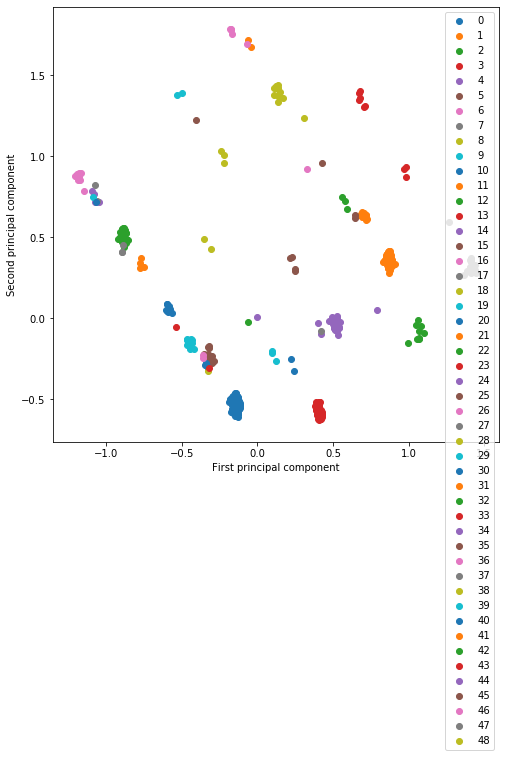

Número de componentes 
    cluster  quant
0         0    192
1         1     53
2         2     48
3         3     34
4         4     22
5         5     17
6         6     14
7         7     13
8         8     12
9         9     11
10       10      9
11       11      9
12       12      8
13       13      6
14       14      4
15       15      4
16       16      4
17       17      3
18       18      3
19       19      3
20       20      3
21       21      3
22       22      3
23       23      3
24       24      2
25       25      2
26       26      2
27       27      2
28       28      2
29       29      2
30       30      2
31       31      2
32       32      1
33       33      1
34       34      1
35       35      1
36       36      1
37       37      1
38       38      1
39       39      1
40       40      1
41       41      1
42       42      1
43       43      1
44       44      1
45       45      1
46       46      1
47       47      1
48       48      1


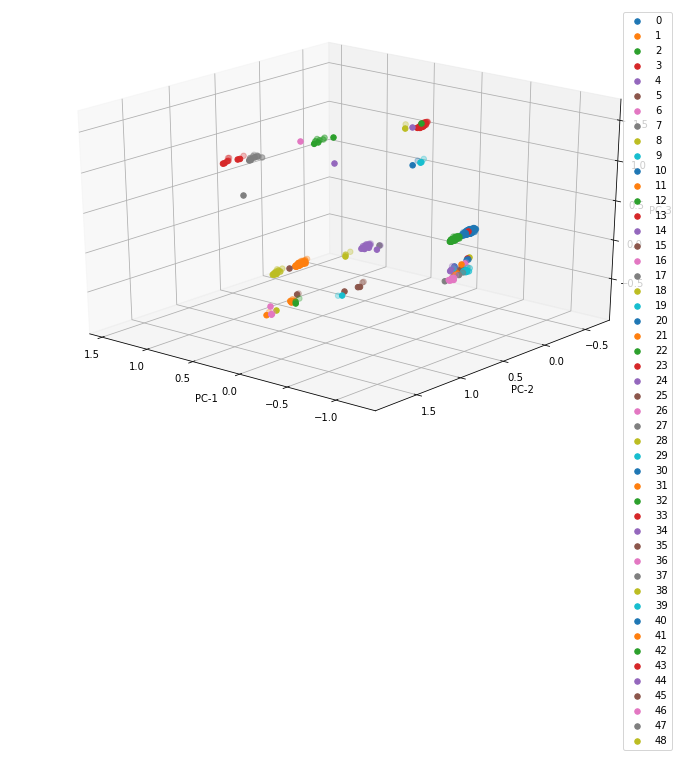

Número de componentes 
    cluster  quant
0         0    192
1         1     53
2         2     48
3         3     34
4         4     22
5         5     17
6         6     14
7         7     13
8         8     12
9         9     11
10       10      9
11       11      9
12       12      8
13       13      6
14       14      4
15       15      4
16       16      4
17       17      3
18       18      3
19       19      3
20       20      3
21       21      3
22       22      3
23       23      3
24       24      2
25       25      2
26       26      2
27       27      2
28       28      2
29       29      2
30       30      2
31       31      2
32       32      1
33       33      1
34       34      1
35       35      1
36       36      1
37       37      1
38       38      1
39       39      1
40       40      1
41       41      1
42       42      1
43       43      1
44       44      1
45       45      1
46       46      1
47       47      1
48       48      1


In [59]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)

In [60]:
df_mean_s=df_original.copy()
df_mean_s["cluster"]=yhat
df_mean_s.sample(5)

,CPF,NM_PUBLICO,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,SG_UF_NASCIMENTO,IDADE,DS_COR_RACA,DS_OCUPACAO,VL_BENS,...,SG_UE,VR_DESPESA_CONTRATADA,LEG_INICIAL,mandatos,cabeças,debatedor,articulador,formulador,negociador,cluster
406,28539249634,Mário Heringer,MASCULINO,SUPERIOR COMPLETO,DIVORCIADO(A),MG,65.0,BRANCA,DEPUTADO,2829690.87,...,MG,2185889.83,52.0,0.0,0.0,0.0,0.0,0.0,0.0,4
496,25630512315,Genecias Noronha,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),CE,57.0,PARDA,EMPRESÁRIO,19044315.00,...,CE,689461.90,54.0,0.0,0.0,0.0,0.0,0.0,0.0,6
309,93876912849,Paulo Freire Costa,MASCULINO,SUPERIOR COMPLETO,CASADO(A),SP,65.0,BRANCA,DEPUTADO,1154699.85,...,SP,2078101.84,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0
359,33205302400,Sergio Toledo,MASCULINO,SUPERIOR COMPLETO,CASADO(A),AL,58.0,BRANCA,DEPUTADO,1501931.90,...,AL,1355557.26,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0
100,88623327420,Gervásio Maia,MASCULINO,SUPERIOR COMPLETO,CASADO(A),SP,45.0,PARDA,DEPUTADO,2893556.70,...,PB,869777.02,56.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [61]:
## DBSCAN

In [62]:
from sklearn.cluster import DBSCAN
modelo = DBSCAN(eps=1, min_samples=10)

In [63]:
modelo.fit(x)
yhat = modelo.fit_predict(x)
clusters = unique(yhat)
#print(preditores)
clusters

DBSCAN(eps=1, min_samples=10)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

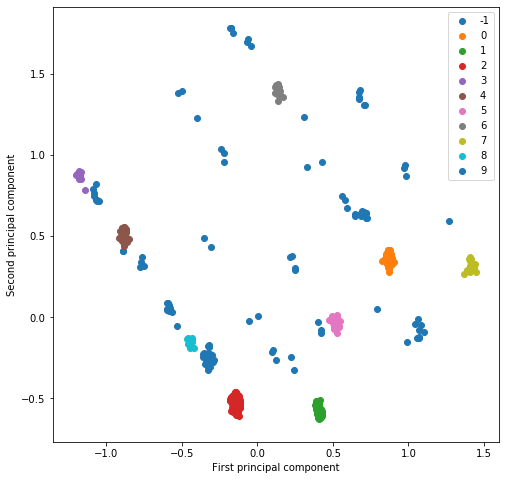

Número de componentes 
    cluster  quant
0        -1     98
1         0     53
2         1     34
3         2    192
4         3     14
5         4     48
6         5     22
7         6     12
8         7     13
9         8     11
10        9     17


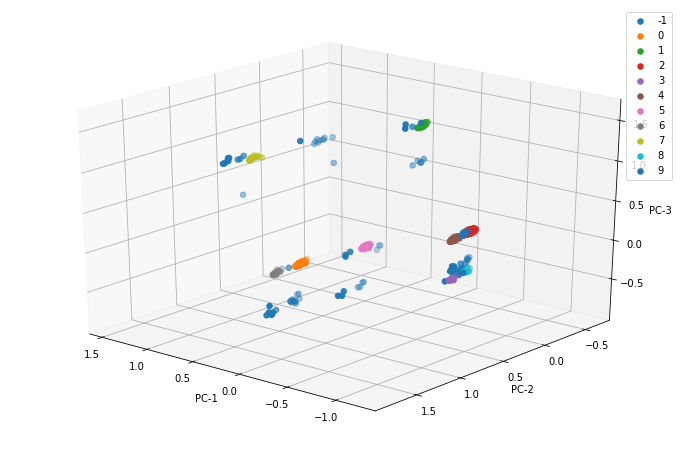

Número de componentes 
    cluster  quant
0        -1     98
1         0     53
2         1     34
3         2    192
4         3     14
5         4     48
6         5     22
7         6     12
8         7     13
9         8     11
10        9     17


In [64]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)

In [65]:
df_dbscan=df_original.copy()
df_dbscan["cluster"]=yhat
df_dbscan.sample(5)

,CPF,NM_PUBLICO,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,SG_UF_NASCIMENTO,IDADE,DS_COR_RACA,DS_OCUPACAO,VL_BENS,...,SG_UE,VR_DESPESA_CONTRATADA,LEG_INICIAL,mandatos,cabeças,debatedor,articulador,formulador,negociador,cluster
426,00213461005,Fernanda Melchionna,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),RS,36.0,BRANCA,VEREADOR,96319.25,...,RS,359172.25,56.0,0.0,0.0,0.0,0.0,0.0,0.0,7
191,11833050100,Dr. Zacharias Calil,MASCULINO,SUPERIOR COMPLETO,CASADO(A),GO,66.0,BRANCA,MÉDICO,3798061.60,...,GO,514550.00,56.0,0.0,0.0,0.0,0.0,0.0,0.0,2
482,02261265794,Evair Vieira de Melo,MASCULINO,SUPERIOR COMPLETO,CASADO(A),ES,48.0,BRANCA,DEPUTADO,9885.89,...,ES,1131526.03,55.0,0.0,0.0,0.0,0.0,0.0,0.0,2
316,00398099863,Carlos Zarattini,MASCULINO,SUPERIOR COMPLETO,SOLTEIRO(A),SP,61.0,BRANCA,DEPUTADO,1051302.81,...,SP,1372580.75,53.0,4.0,8.0,0.0,0.0,0.0,1.0,0
325,59919230510,Jean Wyllys,MASCULINO,SUPERIOR COMPLETO,SOLTEIRO(A),BA,46.0,PRETA,DEPUTADO,1196491.26,...,RJ,388777.43,54.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


## GMM

In [66]:
from sklearn.mixture import GaussianMixture
modelo = GaussianMixture(n_components=25)
modelo.fit(x)
yhat = modelo.predict(x)

GaussianMixture(n_components=25)

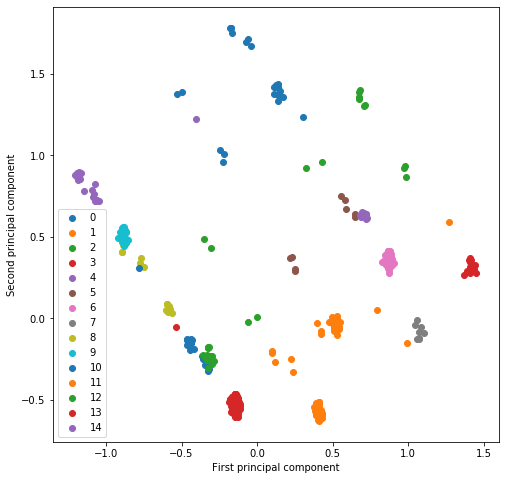

Número de componentes 
    cluster  quant
0         0     25
1         1     42
2         2     15
3         3    193
4         4     23
5         5      9
6         6     53
7         7      8
8         8     15
9         9     48
10       10     19
11       11     25
12       12     17
13       13     13
14       14      9


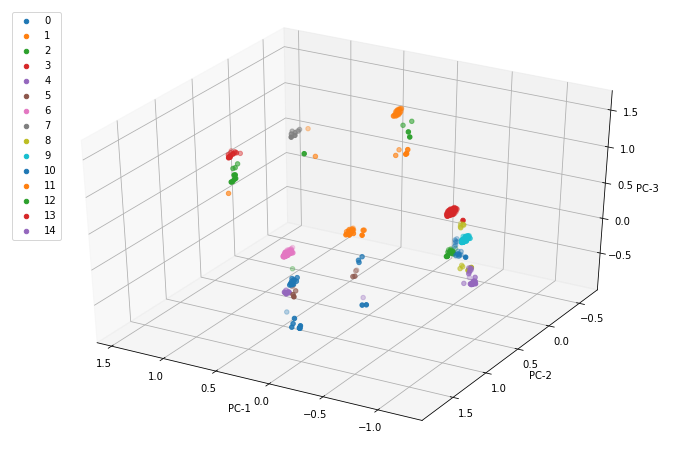

Número de componentes 
    cluster  quant
0         0     25
1         1     42
2         2     15
3         3    193
4         4     23
5         5      9
6         6     53
7         7      8
8         8     15
9         9     48
10       10     19
11       11     25
12       12     17
13       13     13
14       14      9


In [82]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)

In [69]:
df_GMM=df_original.copy()
df_GMM["cluster"]=yhat
df_GMM.sample(5)

,CPF,NM_PUBLICO,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,SG_UF_NASCIMENTO,IDADE,DS_COR_RACA,DS_OCUPACAO,VL_BENS,...,SG_UE,VR_DESPESA_CONTRATADA,LEG_INICIAL,mandatos,cabeças,debatedor,articulador,formulador,negociador,cluster
407,03572972612,Delegado Marcelo Freitas,MASCULINO,SUPERIOR COMPLETO,CASADO(A),MG,44.0,BRANCA,OUTROS,1362047.54,...,MG,353624.00,56.0,0.0,0.0,0.0,0.0,0.0,0.0,13
450,52549810759,Sergio Vidigal,MASCULINO,SUPERIOR COMPLETO,CASADO(A),ES,63.0,PARDA,DEPUTADO,642482.76,...,ES,1482852.67,55.0,0.0,0.0,0.0,0.0,0.0,0.0,1
102,13932772415,Damião Feliciano,MASCULINO,SUPERIOR COMPLETO,CASADO(A),PB,68.0,PRETA,DEPUTADO,1089248.01,...,PB,568905.25,51.0,0.0,0.0,0.0,0.0,0.0,0.0,9
416,02142743730,Carlos Gomes,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),BA,48.0,BRANCA,OUTROS,121327.95,...,RS,881096.17,55.0,0.0,0.0,0.0,0.0,0.0,0.0,11
72,33251797700,Flaviano Melo,MASCULINO,SUPERIOR COMPLETO,DIVORCIADO(A),AC,70.0,BRANCA,DEPUTADO,849999.68,...,AC,1579990.78,53.0,0.0,0.0,0.0,0.0,0.0,0.0,4


## Aglomerative H Cluster

In [70]:
from sklearn.cluster import AgglomerativeClustering
modelo = AgglomerativeClustering(n_clusters=15)
yhat = modelo.fit_predict(x)
clusters = unique(yhat)

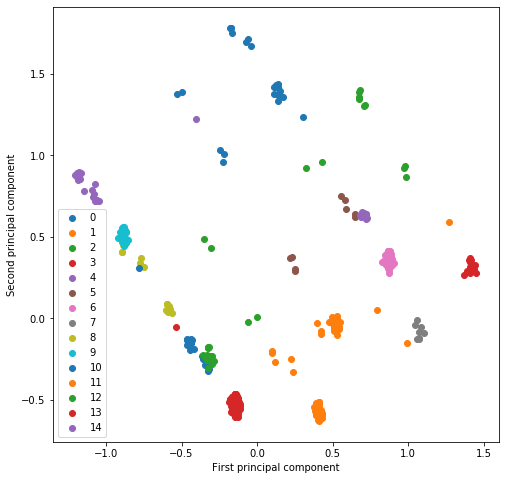

Número de componentes 
    cluster  quant
0         0     25
1         1     42
2         2     15
3         3    193
4         4     23
5         5      9
6         6     53
7         7      8
8         8     15
9         9     48
10       10     19
11       11     25
12       12     17
13       13     13
14       14      9


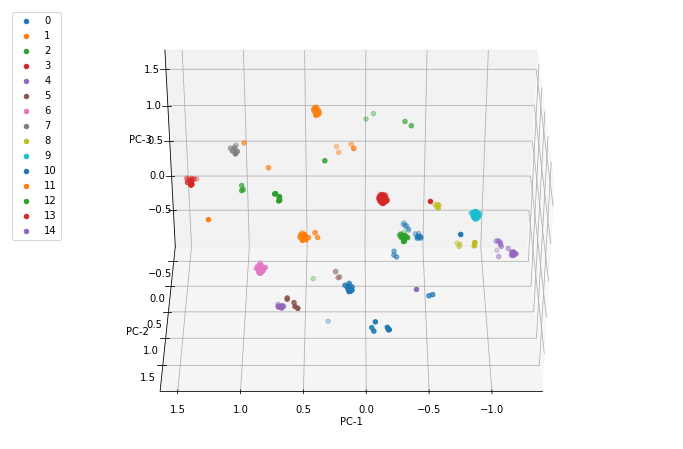

Número de componentes 
    cluster  quant
0         0     25
1         1     42
2         2     15
3         3    193
4         4     23
5         5      9
6         6     53
7         7      8
8         8     15
9         9     48
10       10     19
11       11     25
12       12     17
13       13     13
14       14      9


In [80]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)

In [72]:
df_HC=df_original.copy()
df_HC["cluster"]=yhat
df_HC.sample(5)

,CPF,NM_PUBLICO,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,SG_UF_NASCIMENTO,IDADE,DS_COR_RACA,DS_OCUPACAO,VL_BENS,...,SG_UE,VR_DESPESA_CONTRATADA,LEG_INICIAL,mandatos,cabeças,debatedor,articulador,formulador,negociador,cluster
315,00605387249,Elcione Barbalho,FEMININO,SUPERIOR COMPLETO,DIVORCIADO(A),PA,75.0,BRANCA,DEPUTADO,3613643.30,...,PA,2062624.55,50.0,0.0,0.0,0.0,0.0,0.0,0.0,7
218,13717820249,Bosco Saraiva,MASCULINO,SUPERIOR COMPLETO,CASADO(A),AM,60.0,PARDA,OUTROS,605154.08,...,AM,584781.06,56.0,0.0,0.0,0.0,0.0,0.0,0.0,9
215,86488023420,Felipe Carreras,MASCULINO,SUPERIOR INCOMPLETO,CASADO(A),PE,45.0,BRANCA,DEPUTADO,5975619.27,...,PE,1926907.29,55.0,0.0,0.0,0.0,0.0,0.0,0.0,12
391,21025932072,Onyx Lorenzoni,MASCULINO,SUPERIOR COMPLETO,DIVORCIADO(A),RS,65.0,BRANCA,DEPUTADO,1048635.00,...,RS,1657300.47,52.0,0.0,0.0,0.0,0.0,0.0,0.0,11
77,79981488100,Celina Leão,FEMININO,SUPERIOR COMPLETO,CASADO(A),GO,43.0,BRANCA,DEPUTADO,651965.44,...,DF,2099318.55,56.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## creating a distance matrix using linkage

In [ ]:
# Import the fcluster and linkage functions
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# Use the linkage() function
distance_matrix = linkage(x,method = 'ward', metric = 'euclidean') # method = 'single'/'complete'

# Assign cluster labels
#comic_con['cluster_labels'] = fcluster(distance_matrix, 2, criterion='maxclust')
dendrogram(distance_matrix)

In [ ]:
#dendrogram(distance_matrix)
# Use fcluster to extract labels: labels
clusters = fcluster(distance_matrix, 12, criterion='distance' )
df_ch=df_original.copy()
df_ch["cluster"]=clusters
df_ch.sample(5)

# Avaliação com ARI Adjusted Rand Score Index

In [ ]:
# adjusted rand score is 1, as the clustering is exactly the same
# df_kmeans, df_mean_s, df_dbscan, df_GMM, df_HC, df_ch

In [ ]:
from sklearn.metrics import adjusted_rand_score
target=df_GMM
lista=[df_kmeans,df_mean_s,df_dbscan,df_GMM,df_HC,df_ch]

for df in lista:
    print("ARI: {:.2f}".format(adjusted_rand_score(target["cluster"].values, df["cluster"].values)))


## EDA com K-mean

In [ ]:
df=df_kmeans.copy()

## EDA Básico

In [ ]:
df.shape
df.info()
df.sample(10)

In [ ]:
df.info()
df.describe().round(2)

In [ ]:
plt.clf()
df.hist(figsize=(10,7))
plt.tight_layout()
plt.show

In [ ]:
df.info()
unicos=df.nunique()
unicos

In [ ]:
# Tentar as que tem até 6
unicas=6
variaveis_categoricas=[]
for variavel in unicos.index:
    quant=unicos.loc[variavel]
    if quant <= unicas:
        variaveis_categoricas.append(variavel)
        print("Variavel {}, {} ocorrências únicas".format(variavel,quant))
        print(df[variavel].sort_values().unique())

In [ ]:
variaveis_categoricas

In [ ]:
#variaveis_categoricas.remove("number_project")
#variaveis_categoricas.remove("time_spend_company")
variaveis_categoricas


In [ ]:
df[variaveis_categoricas].info()


In [ ]:
for variavel in variaveis_categoricas:
    df[variavel]=df[variavel].astype("category")
df.info()
#df.describe(include=np.object)

In [ ]:
variaveis_numericas=list((df.columns))
variaveis_numericas=list(set(variaveis_numericas)-set(variaveis_categoricas))
variaveis_numericas

### Histogramas

In [ ]:
for variavel in variaveis_categoricas:
    df[variavel].value_counts().plot(kind="bar")
    plt.xlabel(variavel)
    plt.ylabel("Contagem")
    plt.title(variavel)
    plt.show()

### Boxplots - Identificando, verificando e tratando outliers


In [ ]:
for cat in variaveis_categoricas:
    for num in variaveis_numericas:
        sns.boxplot(x=cat, y=num, data=df)
        plt.xlabel(cat)
        plt.ylabel(num)
        plt.title(cat)
        plt.show()
